# 0. Import the libraries

In [278]:
import numpy as np
import pandas as pd
import missingno as msno
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
from IPython.core.display import HTML, display
from pandas_profiling import ProfileReport
from pathlib import Path
from scipy.stats import probplot, chi2_contingency, chi2
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score, cross_val_predict
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, OrdinalEncoder
from sklearn.inspection import permutation_importance
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, roc_curve, roc_auc_score
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, BaggingClassifier, AdaBoostClassifier, VotingClassifier, ExtraTreesClassifier, StackingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neural_network import MLPClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from imblearn.over_sampling import SMOTE
import joblib
import os
import pickle
import re
import streamlit as st
#from scipy.stats import norm
%matplotlib inline

# 1. Frame the problem and look at the big picture

## 1.1 Define the objective in business terms.

Determine if the income of a person is greater or less than 50k

## 1.2 How will your solution be used?

The solution can be use in the bank industry for loan applications, it could also be use at the dearship for a car financing.

## 1.3 What are the current solutions/workarounds (if any)?

Not applicable

## 1.4 How should you frame this problem (supervised/unsupervised, online/offline, etc.)

Supervised Learning, Batch learning, Model-based learning.

## 1.5 How should performance be measured?

Classification metrics which are: Accuracy score, Confustion matrix, Classification report, Precision, Recall, F1 score, ROC curve, AUC, Precision-Recall curve

## 1.6 Is the performance measure aligned with the business objective?

Not applicable

## 1.7 What would be the minimum performance needed to reach the business objective?

A subjective accuracy of more than 80%.

## 1.8 What are comparable problems? Can you reuse experience or tools?

Not applicable

## 1.9 Is human expertise available?

No

## 1.10 How would you solve the problem manually?

By looking at each person information and determine if they have an income higher than 50K which is a tedious task.

## 1.11 List the assumptions you or others have made so far.

Some of the assumptions would be that education, occupation, race , gender and native country might influence the target. To be verified

## 1.12 Verify assumptions if possible.

To be verified

# 2. Get the data

## 2.1 List the data you need and how much you need.

Will use the data from the train and test datasets.

## 2.2 Find and document where you can get that data.

Done!

## 2.3 Check how much space it will take.

less than 5 Megabytes.

## 2.4 Check legal obligations, and get the authorization if necessary.

Not applicable

## 2.5 Get access authorizations.

Not applicable

## 2.6 Create a workspace (with enough storage space).

No need

## 2.7 Get the data.

In [279]:
train_original = pd.read_csv('datasets/train.csv')

## 2.8 Convert the data to a format you can easily manipulate (without changing the data itself).

Data already in a good format

## 2.9 Ensure sensitive information is deleted or protected (e.g., anonymized).

Not applicable

## 2.10 Check the size and type of data (time series, sample, geographical, etc.).

~ 5 MB of tabular data

## 2.11 Sample a test set, put it aside, and never look at it (no data snooping!).

In [280]:
test_original = pd.read_csv('datasets/test.csv')

In [281]:
full_data = pd.concat([train_original, test_original], axis=0)

In [282]:
# shuffle the data
full_data = full_data.sample(frac=1).reset_index(drop=True)

In [283]:
full_data.shape

(44856, 15)

In [284]:
# split the data into train and test
def data_split(df, test_size):
    train_df, test_df = train_test_split(df, test_size=test_size, random_state=42)
    return train_df.reset_index(drop=True), test_df.reset_index(drop=True)

In [285]:
train_original, test_original = data_split(full_data, 0.2)

In [286]:
train_original.shape

(35884, 15)

In [287]:
test_original.shape

(8972, 15)

In [288]:
train_copy = train_original.copy()
test_copy = test_original.copy()

# 3. Explore the data

## 3.1 Create a copy of the data for exploration (sampling it down to a manageable size if necessary).

Not necessary

## 3.2 Create a Jupyter notebook to keep record of your data exploration.

Done!

## 3.3 Quick overview of the data

In [289]:
train_copy.head()

age         workclass  fnlwgt  education  educational-num  \
0   28           Private  103802  Bachelors               13   
1   41           Private   56795    Masters               14   
2   29  Self-emp-not-inc   33798    HS-grad                9   
3   25         State-gov  143062    HS-grad                9   
4   19           Private   95078    HS-grad                9   

       marital-status        occupation relationship   race  gender  \
0       Never-married   Exec-managerial    Own-child  White  Female   
1  Married-civ-spouse    Prof-specialty         Wife  White  Female   
2  Married-civ-spouse  Transport-moving      Husband  White    Male   
3       Never-married      Adm-clerical    Own-child  White  Female   
4       Never-married      Adm-clerical    Own-child  White  Female   

   capital-gain  capital-loss  hours-per-week native-country  income_>50K  
0             0          1408              40            NaN        0.000  
1             0             0              45        England        0.000  
2             0             0              45  United-States          NaN  
3             0             0              40  United-States        0.000  
4             0             0              15  United-States        0.000

In [290]:
train_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35884 entries, 0 to 35883
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   age              35884 non-null  int64  
 1   workclass        33885 non-null  object 
 2   fnlwgt           35884 non-null  int64  
 3   education        35884 non-null  object 
 4   educational-num  35884 non-null  int64  
 5   marital-status   35884 non-null  object 
 6   occupation       33879 non-null  object 
 7   relationship     35884 non-null  object 
 8   race             35884 non-null  object 
 9   gender           35884 non-null  object 
 10  capital-gain     35884 non-null  int64  
 11  capital-loss     35884 non-null  int64  
 12  hours-per-week   35884 non-null  int64  
 13  native-country   35261 non-null  object 
 14  income_>50K      35171 non-null  float64
dtypes: float64(1), int64(6), object(8)
memory usage: 4.1+ MB


In [291]:
train_copy.describe()

age      fnlwgt  educational-num  capital-gain  capital-loss  \
count 35884.000   35884.000        35884.000     35884.000     35884.000   
mean     38.587  189377.819           10.080      1083.889        89.856   
std      13.688  105957.641            2.574      7499.992       408.524   
min      17.000   13492.000            1.000         0.000         0.000   
25%      28.000  117166.750            9.000         0.000         0.000   
50%      37.000  177876.500           10.000         0.000         0.000   
75%      48.000  237379.000           12.000         0.000         0.000   
max      90.000 1490400.000           16.000     99999.000      4356.000   

       hours-per-week  income_>50K  
count       35884.000    35171.000  
mean           40.437        0.240  
std            12.348        0.427  
min             1.000        0.000  
25%            40.000        0.000  
50%            40.000        0.000  
75%            45.000        0.000  
max            99.000        1.000

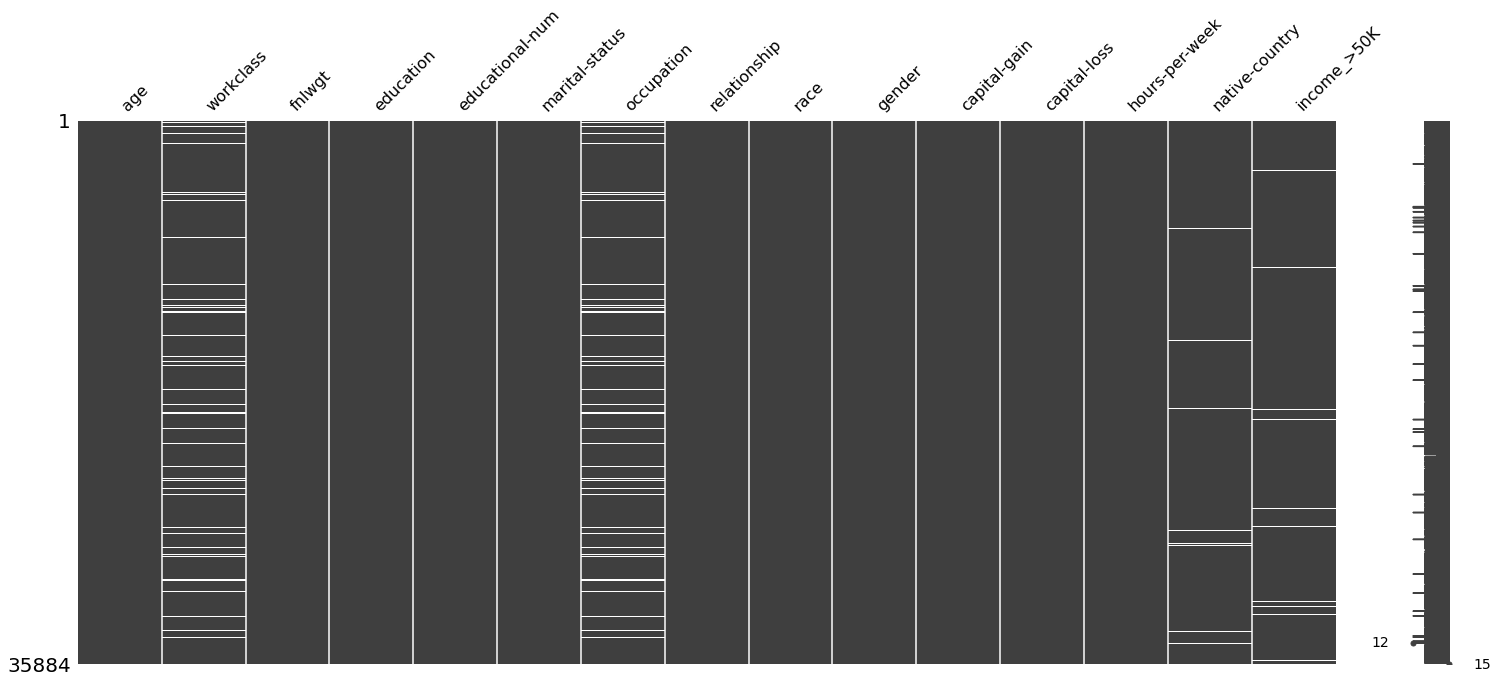

In [292]:
msno.matrix(train_copy)
plt.show()

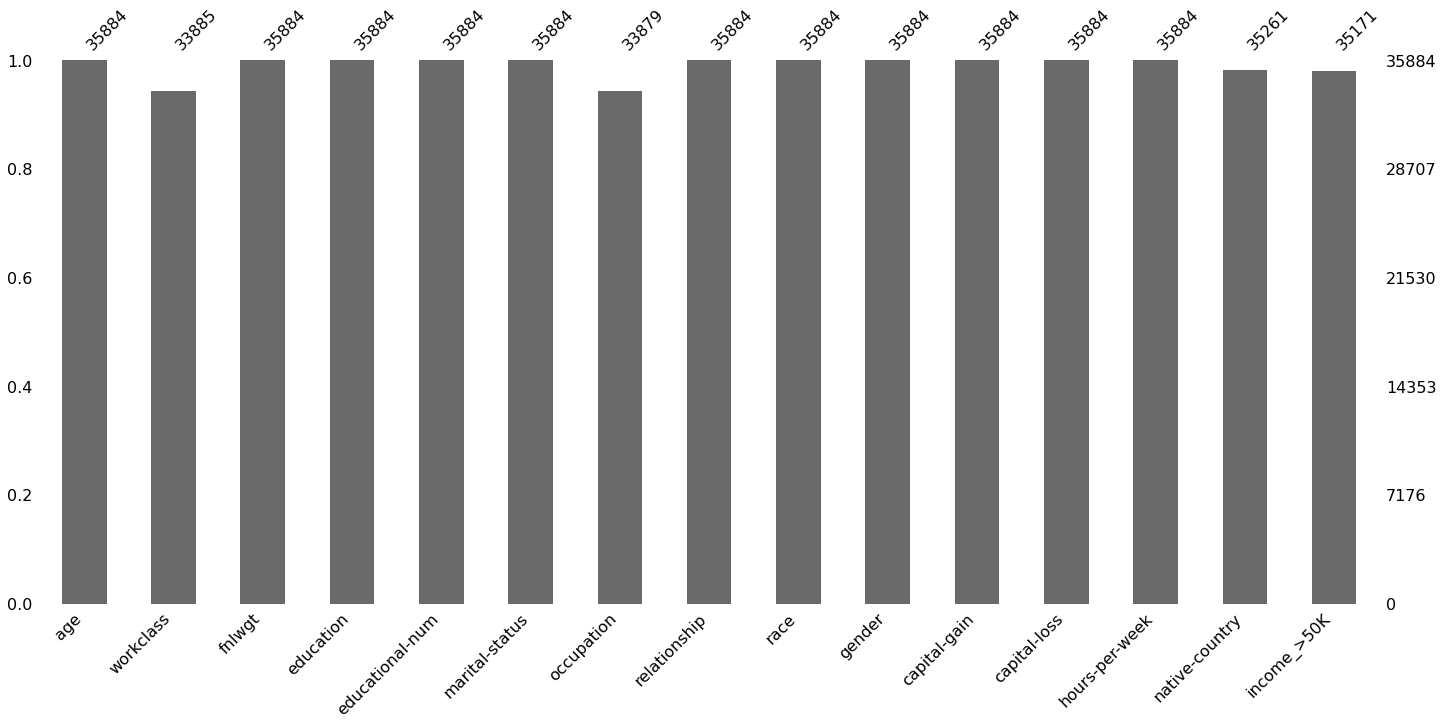

In [293]:
msno.bar(train_copy)
plt.show()

In [294]:
#profile_report = ProfileReport(train_copy, explorative=True, dark_mode=True)

In [295]:
profile_report_file_path = Path('income_class_profile.html')

try:
    profile_report_file_path.resolve(strict=True)
except FileNotFoundError:
    profile_report.to_file("income_class_profile.html")
else:
    pass

## 3.4 Study each attribute and its characteristics:
## - Name
## - Type (categorical, int/float, bounded/unbounded, text, structured, etc.)
## - % of missing values
## - Noisiness and type of noise (stochastic, outliers, rounding errors, etc.)
## - Possibly useful for the task?
## - Type of distribution (Gaussian, uniform, logarithmic, etc.)

In [296]:
#Function that will return the value count and frequency of each observation within a column
def value_cnt_norm_cal(df,feature):
    ftr_value_cnt = df[feature].value_counts()
    ftr_value_cnt_norm = df[feature].value_counts(normalize=True) * 100
    ftr_value_cnt_concat = pd.concat([ftr_value_cnt, ftr_value_cnt_norm], axis=1)
    ftr_value_cnt_concat.columns = ['Count', 'Frequency (%)']
    return ftr_value_cnt_concat

### 3.4.1 Age

In [297]:
train_copy['age'].head()

0    28
1    41
2    29
3    25
4    19
Name: age, dtype: int64

In [298]:
train_copy['age'].describe()

count   35884.000
mean       38.587
std        13.688
min        17.000
25%        28.000
50%        37.000
75%        48.000
max        90.000
Name: age, dtype: float64

In [299]:
train_copy['age'].dtype

dtype('int64')

In [300]:
train_copy['age'].isnull().sum()

0

In [301]:
age_value_cnt_norm = train_copy['age'].value_counts(normalize=True) * 100

In [302]:
age_value_cnt = train_copy['age'].value_counts()

In [303]:
value_cnt_norm_cal(train_copy, 'age')

Count  Frequency (%)
36    992          2.764
35    990          2.759
33    979          2.728
28    978          2.725
23    967          2.695
..    ...            ...
88      5          0.014
85      2          0.006
89      2          0.006
87      1          0.003
86      1          0.003

[74 rows x 2 columns]

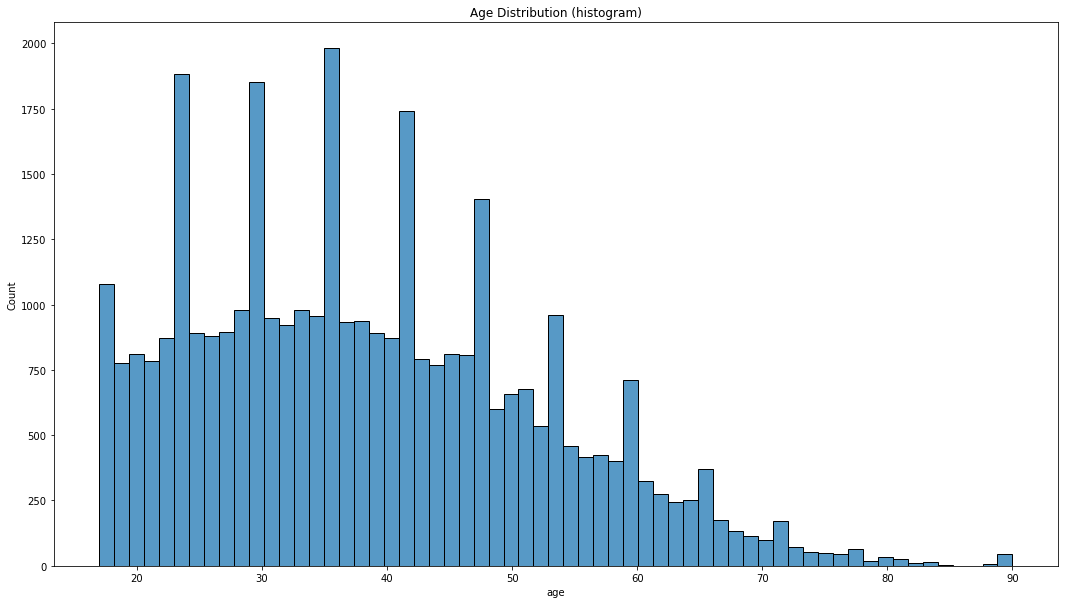

In [304]:
fig, ax = plt.subplots(figsize=(18,10))
sns.histplot(train_copy['age'])
plt.title('Age Distribution (histogram)')
plt.show()

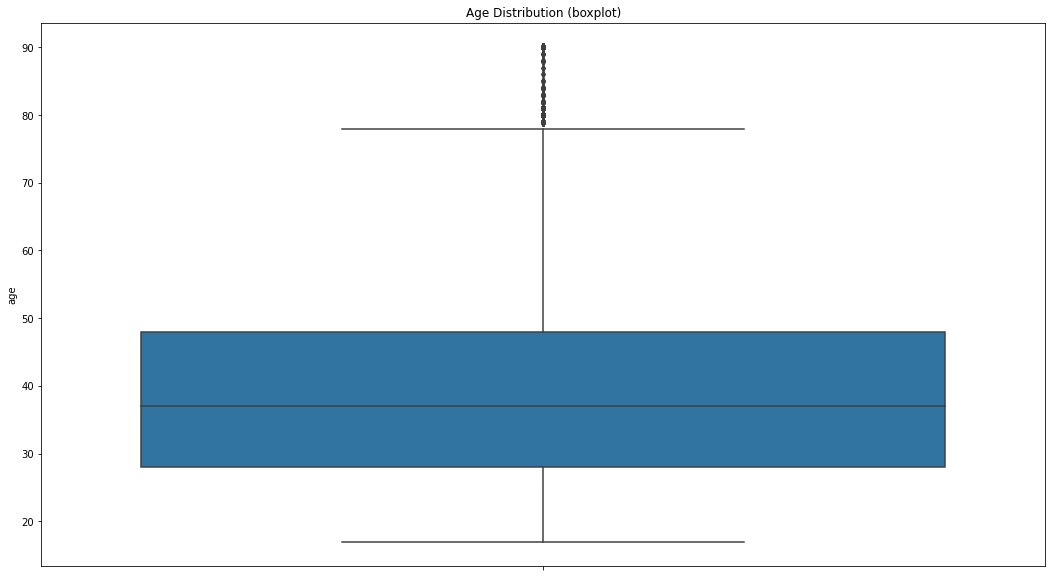

In [305]:
fig, ax = plt.subplots(figsize=(18,10))
sns.boxplot(y=train_copy['age'])
plt.title('Age Distribution (boxplot)')
plt.show()

In [306]:
# TODO: Age is might be useful for the model, will keep it for now

### 3.4.2 Workclass

In [307]:
train_copy['workclass'].dtype

dtype('O')

In [308]:
train_copy['workclass'].head()

0             Private
1             Private
2    Self-emp-not-inc
3           State-gov
4             Private
Name: workclass, dtype: object

In [309]:
value_cnt_norm_cal(train_copy,'workclass')

Count  Frequency (%)
Private           25067         73.977
Self-emp-not-inc   2825          8.337
Local-gov          2264          6.681
State-gov          1423          4.199
Self-emp-inc       1243          3.668
Federal-gov        1044          3.081
Without-pay          13          0.038
Never-worked          6          0.018

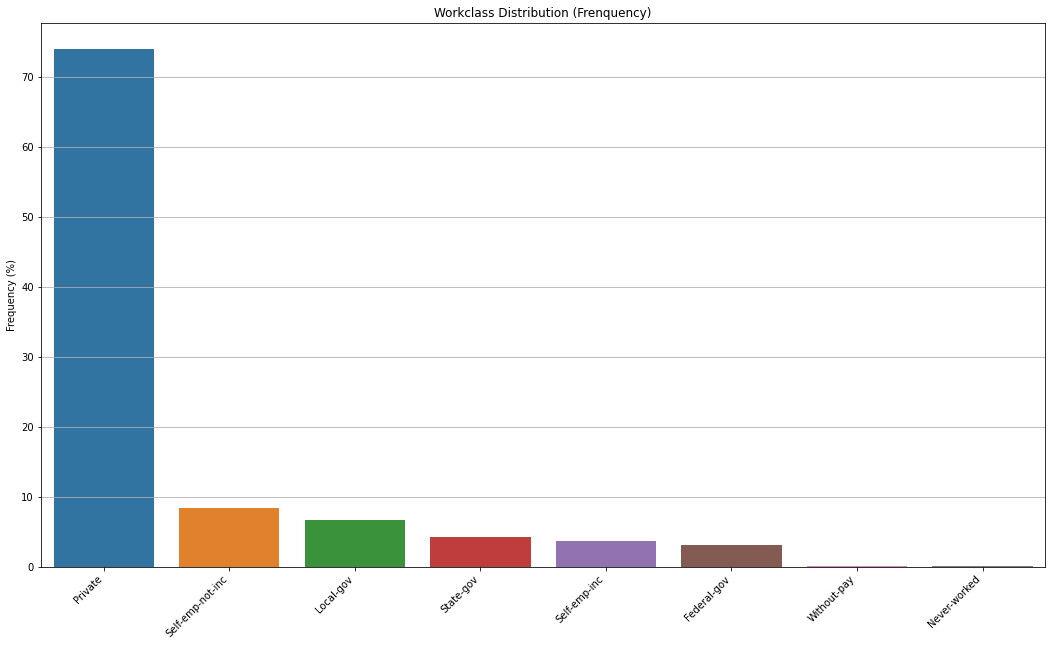

In [310]:
fig, ax = plt.subplots(figsize=(18,10))
sns.barplot(x=value_cnt_norm_cal(train_copy,'workclass').index, y=value_cnt_norm_cal(train_copy,'workclass')['Frequency (%)'])
plt.title('Workclass Distribution (Frenquency)')
plt.grid(True,axis='y')
plt.xticks(rotation=45,ha='right')
plt.show()

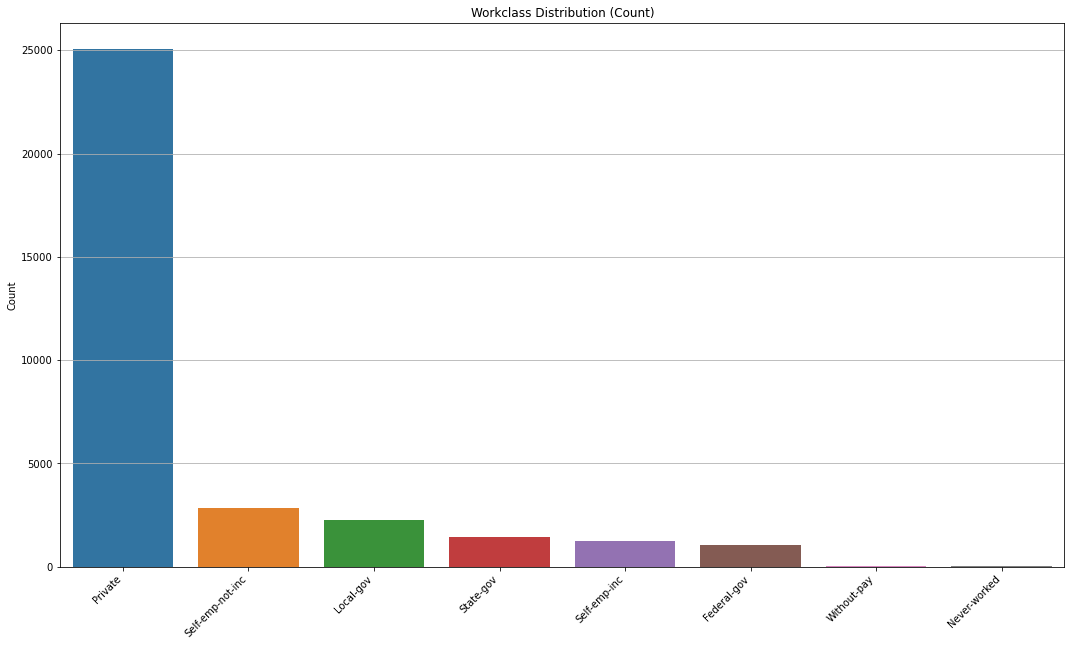

In [311]:
fig, ax = plt.subplots(figsize=(18,10))
sns.barplot(x=value_cnt_norm_cal(train_copy,'workclass').index, y=value_cnt_norm_cal(train_copy,'workclass')['Count'])
plt.title('Workclass Distribution (Count)')
plt.grid(True,axis='y')
plt.xticks(rotation=45,ha='right')
plt.show()

In [312]:
train_copy['workclass'].isnull().sum()

1999

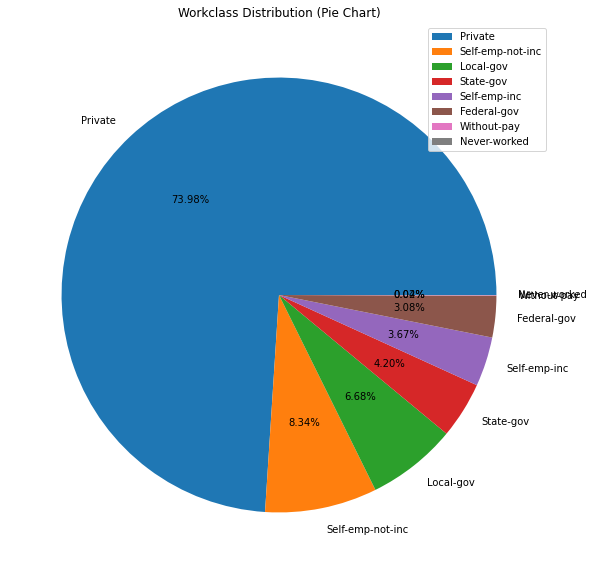

In [313]:
fig, ax = plt.subplots(figsize=(18,10))
plt.pie(train_copy['workclass'].value_counts(), labels=train_copy['workclass'].value_counts().index, autopct='%1.2f%%')
plt.title('Workclass Distribution (Pie Chart)')
plt.legend(loc='upper right')
plt.show()

In [314]:
# TODO: workclass is might be useful for the model, will keep it for now

### 3.4.3 Final weight

Its a weight assigned by the Census Bureau. **The idea is that if two samples have the same(or similar) fnlwgt they have similar characteristics, demographically speaking. **Say sample 7,12 and 33 are having similar fnlwgt values they are more likely to be of the same race, similar educational and social background, etc.. but if you are planning to use it, you should be aware that they are not standardized across different states/country. So someone in one country might share similar fnlwgt with somebody in another country but might have entirely different socio-economic background.

In [315]:
train_copy['fnlwgt'].dtype

dtype('int64')

In [316]:
train_copy['fnlwgt'].head()

0    103802
1     56795
2     33798
3    143062
4     95078
Name: fnlwgt, dtype: int64

In [317]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
train_copy['fnlwgt'].describe()

count     35884.000
mean     189377.819
std      105957.641
min       13492.000
25%      117166.750
50%      177876.500
75%      237379.000
max     1490400.000
Name: fnlwgt, dtype: float64

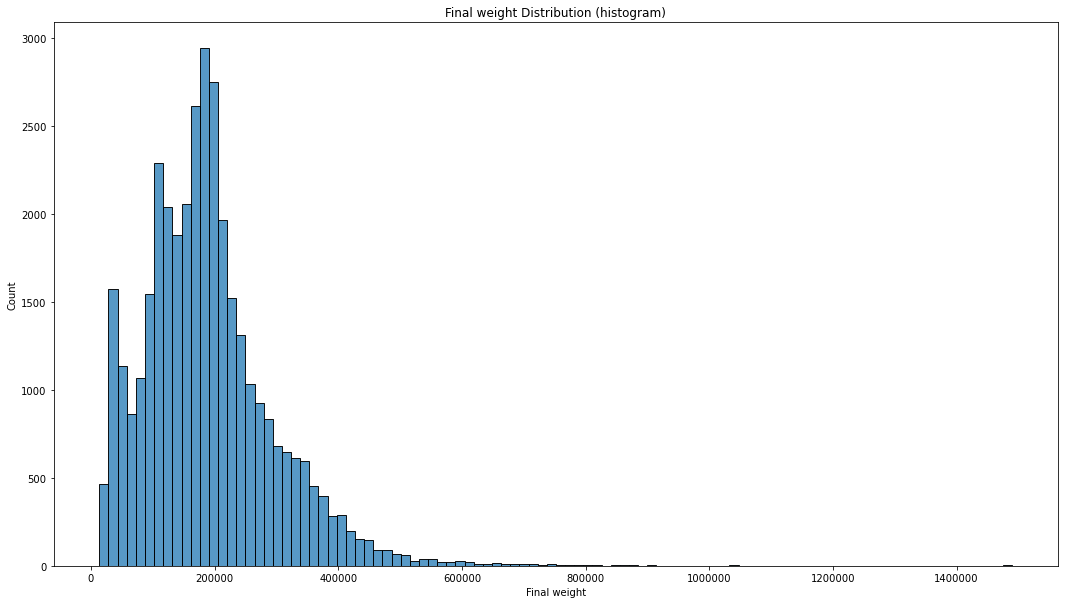

In [318]:
fig, ax = plt.subplots(figsize=(18,10))
ax.ticklabel_format(style='plain')
sns.histplot(train_copy['fnlwgt'],bins=100)
plt.title('Final weight Distribution (histogram)')
plt.xlabel('Final weight')
plt.show()

In [319]:
# TODO: Not sure if this feature is useful, will keep it for now. Will run the feature im and see if this is useful

### 3.4.4. Education

In [320]:
train_copy['education'].dtype

dtype('O')

In [321]:
train_copy['education'].head()

0    Bachelors
1      Masters
2      HS-grad
3      HS-grad
4      HS-grad
Name: education, dtype: object

In [322]:
train_copy['education'].isnull().sum()

0

In [323]:
value_cnt_norm_cal(train_copy,'education')

Count  Frequency (%)
HS-grad       11570         32.243
Some-college   8002         22.300
Bachelors      5907         16.461
Masters        1979          5.515
Assoc-voc      1483          4.133
11th           1331          3.709
Assoc-acdm     1195          3.330
10th           1017          2.834
7th-8th         700          1.951
Prof-school     613          1.708
9th             561          1.563
12th            478          1.332
Doctorate       427          1.190
5th-6th         373          1.039
1st-4th         184          0.513
Preschool        64          0.178

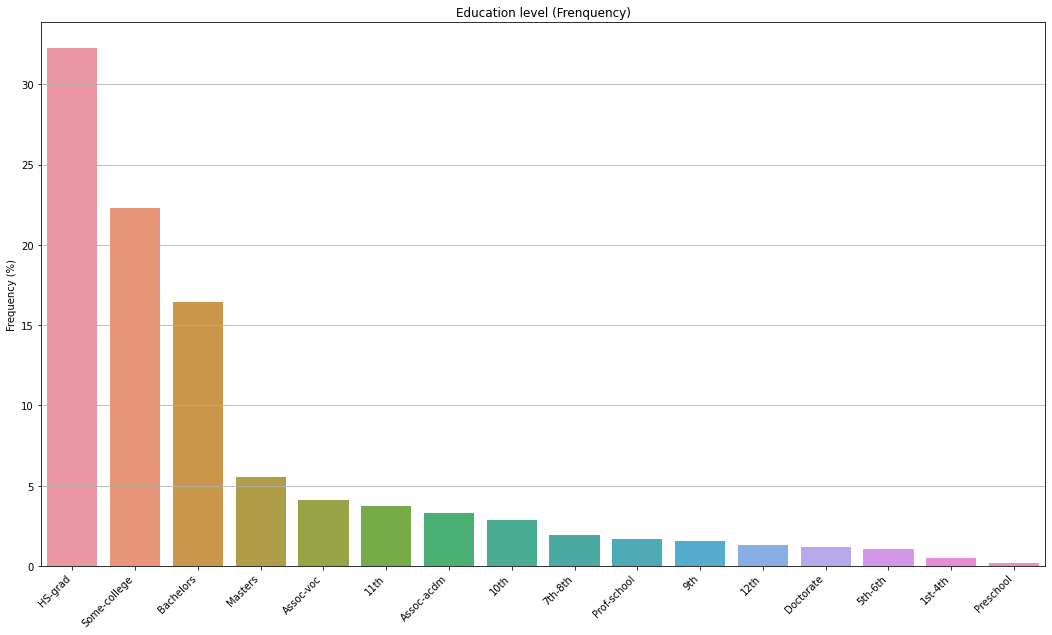

In [324]:
fig, ax = plt.subplots(figsize=(18,10))
sns.barplot(x=value_cnt_norm_cal(train_copy,'education').index, y=value_cnt_norm_cal(train_copy,'education')['Frequency (%)'])
plt.title('Education level (Frenquency)')
plt.grid(True,axis='y')
plt.xticks(rotation=45,ha='right')
plt.show()

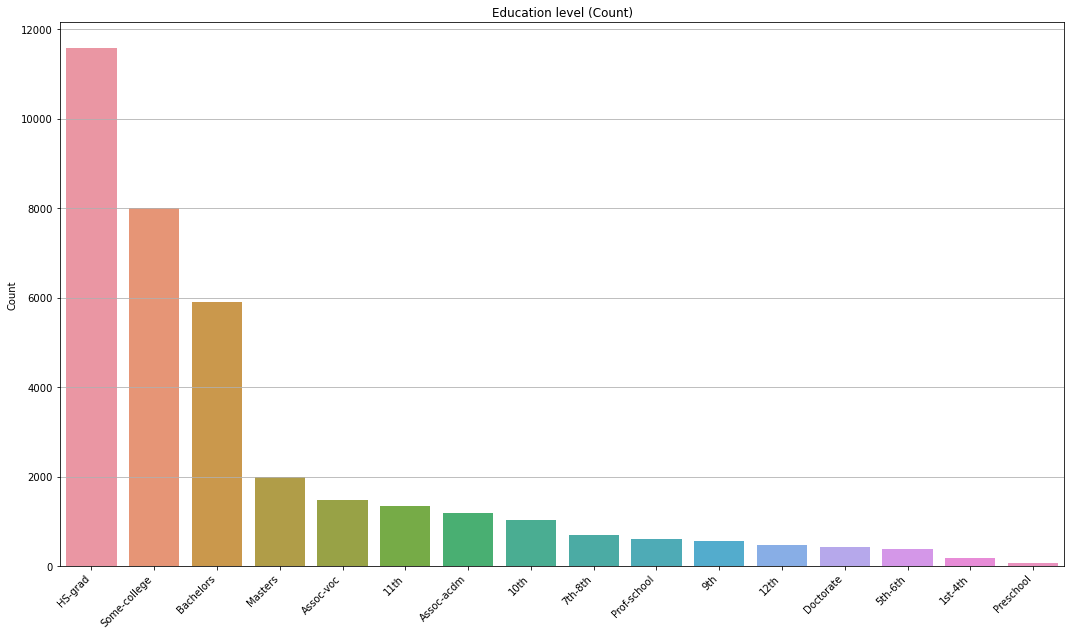

In [325]:
fig, ax = plt.subplots(figsize=(18,10))
sns.barplot(x=value_cnt_norm_cal(train_copy,'education').index, y=value_cnt_norm_cal(train_copy,'education')['Count'])
plt.title('Education level (Count)')
plt.grid(True,axis='y')
plt.xticks(rotation=45,ha='right')
plt.show()

In [326]:
# TODO: education level is might be useful for the model, will keep it for now

### 3.4.5 education number

In [327]:
train_copy['educational-num'].dtype

dtype('int64')

In [328]:
train_copy['educational-num'].head()

0    13
1    14
2     9
3     9
4     9
Name: educational-num, dtype: int64

In [329]:
train_copy['educational-num'].value_counts()

9     11570
10     8002
13     5907
14     1979
11     1483
7      1331
12     1195
6      1017
4       700
15      613
5       561
8       478
16      427
3       373
2       184
1        64
Name: educational-num, dtype: int64

In [330]:
train_copy[['education','educational-num']].nunique()

education          16
educational-num    16
dtype: int64

In [331]:
train_copy[['education','educational-num']].value_counts()

education     educational-num
HS-grad       9                  11570
Some-college  10                  8002
Bachelors     13                  5907
Masters       14                  1979
Assoc-voc     11                  1483
11th          7                   1331
Assoc-acdm    12                  1195
10th          6                   1017
7th-8th       4                    700
Prof-school   15                   613
9th           5                    561
12th          8                    478
Doctorate     16                   427
5th-6th       3                    373
1st-4th       2                    184
Preschool     1                     64
dtype: int64

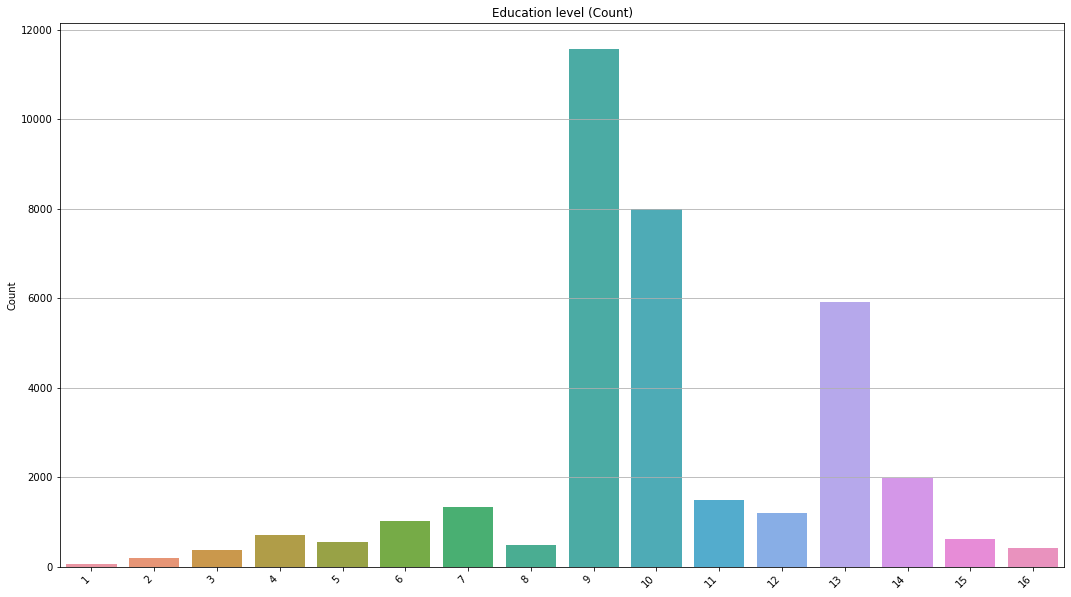

In [332]:
fig, ax = plt.subplots(figsize=(18,10))
sns.barplot(x=value_cnt_norm_cal(train_copy,'educational-num').index, y=value_cnt_norm_cal(train_copy,'educational-num')['Count'])
plt.title('Education level (Count)')
plt.grid(True,axis='y')
plt.xticks(rotation=45,ha='right')
plt.show()

In [333]:
# TODO: since education-num is essentially an encoded version of education, will need to drop this feature and keep education for now.

### 3.4.6 Marital Status

In [334]:
train_copy['marital-status'].dtype

dtype('O')

In [335]:
train_copy['marital-status'].head()

0         Never-married
1    Married-civ-spouse
2    Married-civ-spouse
3         Never-married
4         Never-married
Name: marital-status, dtype: object

In [336]:
train_copy['marital-status'].isnull().sum()

0

In [337]:
value_cnt_norm_cal(train_copy,'marital-status')

Count  Frequency (%)
Married-civ-spouse     16455         45.856
Never-married          11845         33.009
Divorced                4874         13.583
Separated               1118          3.116
Widowed                 1102          3.071
Married-spouse-absent    463          1.290
Married-AF-spouse         27          0.075

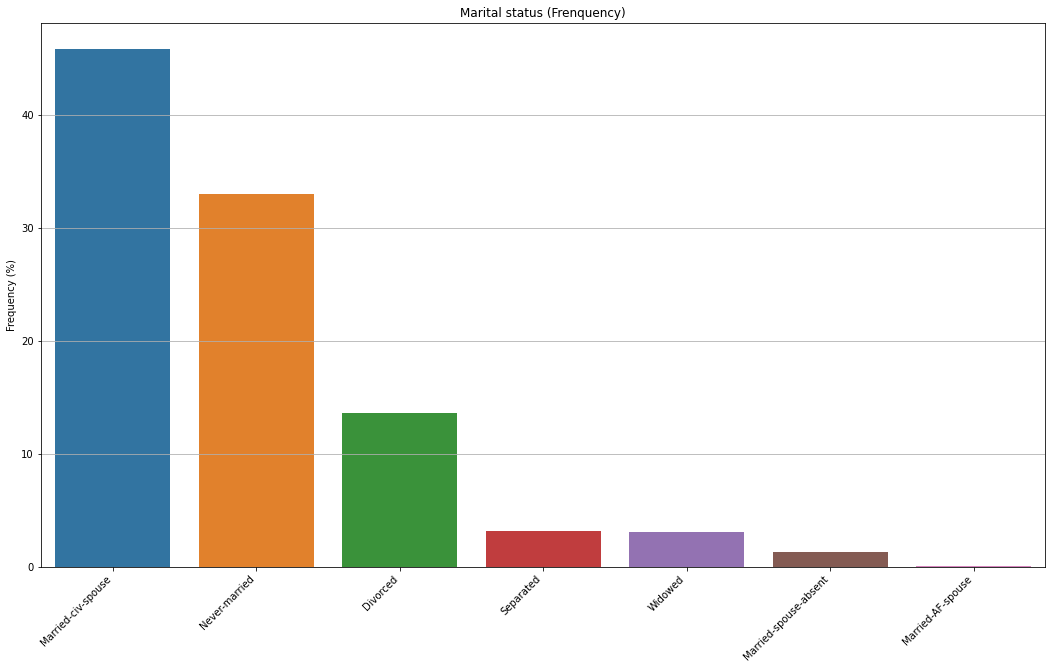

In [338]:
fig, ax = plt.subplots(figsize=(18,10))
sns.barplot(x=value_cnt_norm_cal(train_copy,'marital-status').index, y=value_cnt_norm_cal(train_copy,'marital-status')['Frequency (%)'])
plt.title('Marital status (Frenquency)')
plt.grid(True,axis='y')
plt.xticks(rotation=45,ha='right')
plt.show()

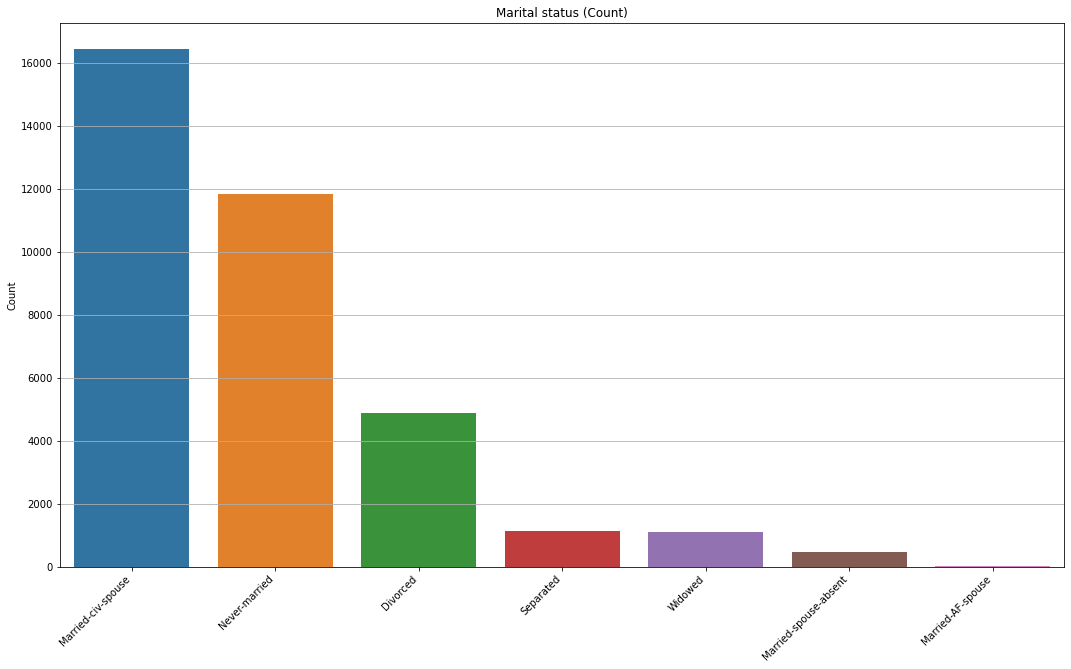

In [339]:
fig, ax = plt.subplots(figsize=(18,10))
sns.barplot(x=value_cnt_norm_cal(train_copy,'marital-status').index, y=value_cnt_norm_cal(train_copy,'marital-status')['Count'])
plt.title('Marital status (Count)')
plt.grid(True,axis='y')
plt.xticks(rotation=45,ha='right')
plt.show()

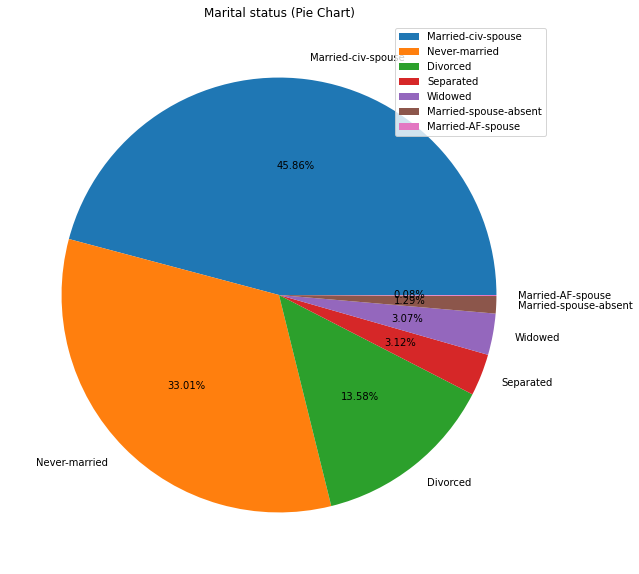

In [340]:
fig, ax = plt.subplots(figsize=(18,10))
plt.pie(train_copy['marital-status'].value_counts(), labels=train_copy['marital-status'].value_counts().index, autopct='%1.2f%%')
plt.title('Marital status (Pie Chart)')
plt.legend(loc='upper right')
plt.show()

### 3.4.7 Occupation

In [341]:
train_copy['occupation'].dtype

dtype('O')

In [342]:
train_copy['occupation'].head()

0     Exec-managerial
1      Prof-specialty
2    Transport-moving
3        Adm-clerical
4        Adm-clerical
Name: occupation, dtype: object

In [343]:
train_copy['occupation'].isnull().sum()

2005

In [344]:
train_copy['occupation'].value_counts()

Prof-specialty       4571
Exec-managerial      4531
Craft-repair         4505
Adm-clerical         4086
Sales                4043
Other-service        3647
Machine-op-inspct    2231
Transport-moving     1716
Handlers-cleaners    1510
Tech-support         1083
Farming-fishing      1070
Protective-serv       685
Priv-house-serv       188
Armed-Forces           13
Name: occupation, dtype: int64

In [345]:
train_copy['occupation'].nunique()

14

In [346]:
value_cnt_norm_cal(train_copy,'occupation')

Count  Frequency (%)
Prof-specialty      4571         13.492
Exec-managerial     4531         13.374
Craft-repair        4505         13.297
Adm-clerical        4086         12.061
Sales               4043         11.934
Other-service       3647         10.765
Machine-op-inspct   2231          6.585
Transport-moving    1716          5.065
Handlers-cleaners   1510          4.457
Tech-support        1083          3.197
Farming-fishing     1070          3.158
Protective-serv      685          2.022
Priv-house-serv      188          0.555
Armed-Forces          13          0.038

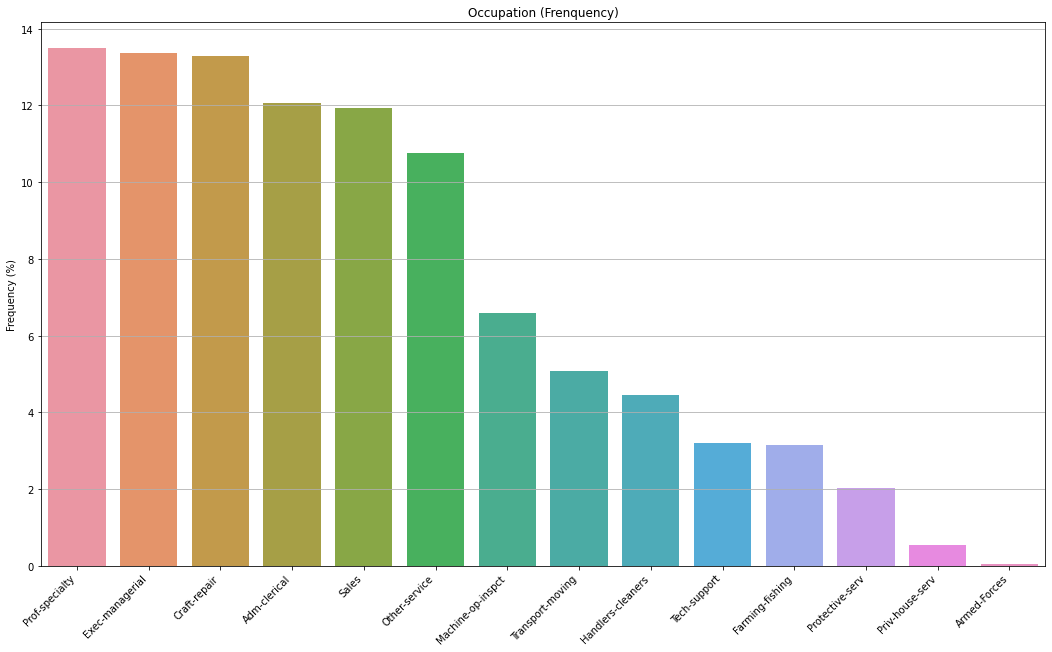

In [347]:
fig, ax = plt.subplots(figsize=(18,10))
sns.barplot(x=value_cnt_norm_cal(train_copy,'occupation').index, y=value_cnt_norm_cal(train_copy,'occupation')['Frequency (%)'])
plt.title('Occupation (Frenquency)')
plt.grid(True,axis='y')
plt.xticks(rotation=45,ha='right')
plt.show()

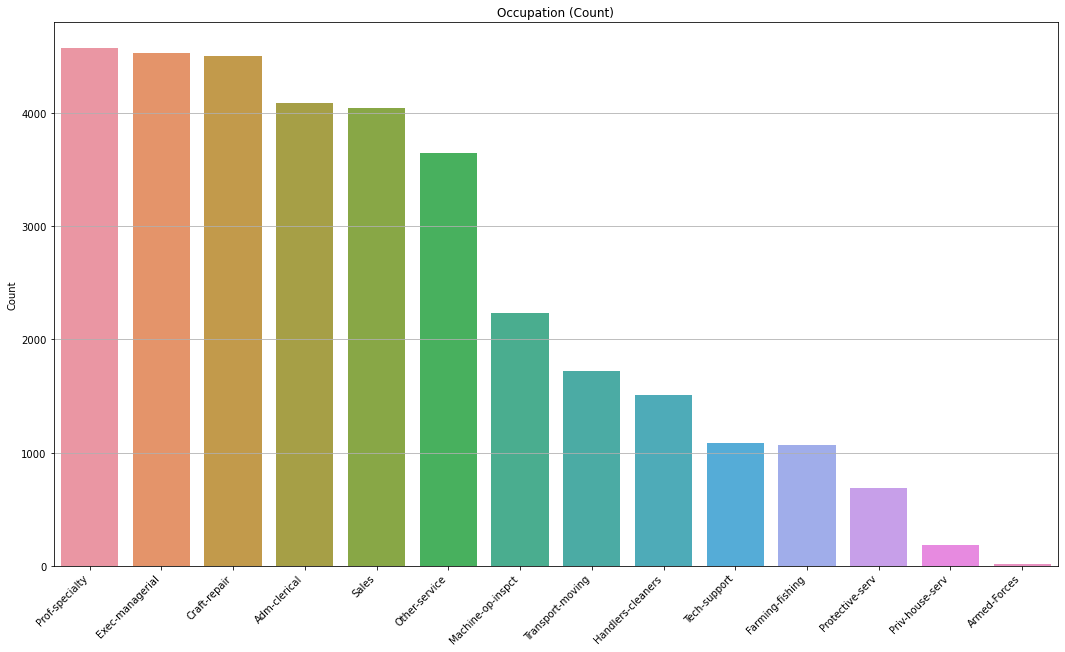

In [348]:
fig, ax = plt.subplots(figsize=(18,10))
sns.barplot(x=value_cnt_norm_cal(train_copy,'occupation').index, y=value_cnt_norm_cal(train_copy,'occupation')['Count'])
plt.title('Occupation (Count)')
plt.grid(True,axis='y')
plt.xticks(rotation=45,ha='right')
plt.show()

In [349]:
## TODO: occupation is highly correlated with workclass, has almost the same missing value like workclass and gives less info than workclass. we might need to drop this feature.

### 3.4.8 relationship

In [350]:
train_copy['relationship'].dtype

dtype('O')

In [351]:
train_copy['relationship'].head()

0    Own-child
1         Wife
2      Husband
3    Own-child
4    Own-child
Name: relationship, dtype: object

In [352]:
train_copy['relationship'].value_counts()

Husband           14497
Not-in-family      9199
Own-child          5576
Unmarried          3795
Wife               1712
Other-relative     1105
Name: relationship, dtype: int64

In [353]:
train_copy['relationship'].isnull().sum()

0

In [354]:
value_cnt_norm_cal(train_copy,'relationship')

Count  Frequency (%)
Husband         14497         40.400
Not-in-family    9199         25.635
Own-child        5576         15.539
Unmarried        3795         10.576
Wife             1712          4.771
Other-relative   1105          3.079

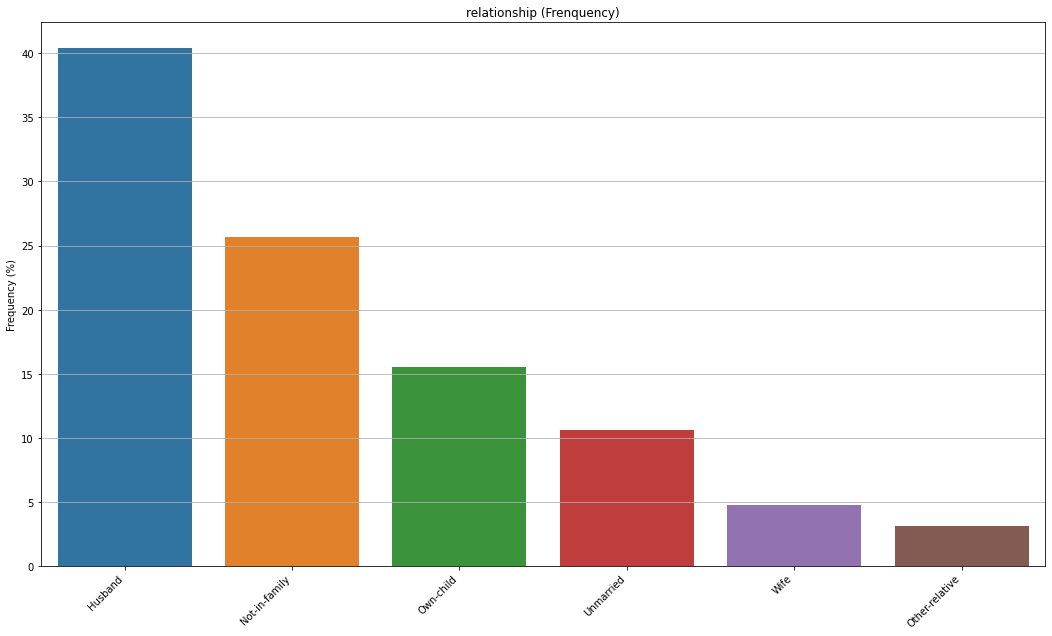

In [355]:
fig, ax = plt.subplots(figsize=(18,10))
sns.barplot(x=value_cnt_norm_cal(train_copy,'relationship').index, y=value_cnt_norm_cal(train_copy,'relationship')['Frequency (%)'])
plt.title('relationship (Frenquency)')
plt.grid(True,axis='y')
plt.xticks(rotation=45,ha='right')
plt.show()

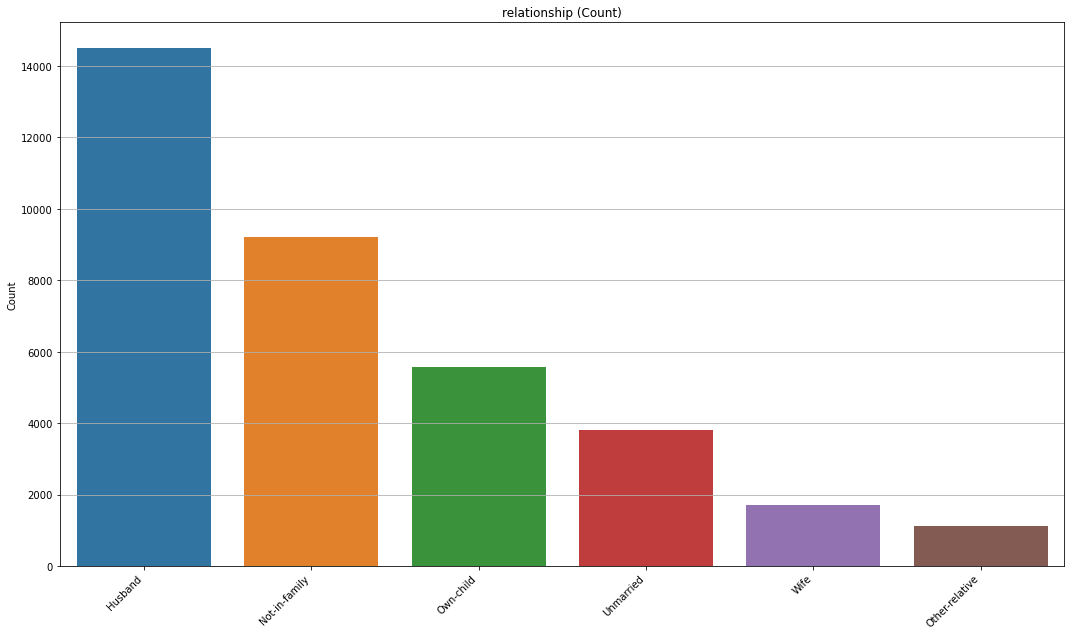

In [356]:
fig, ax = plt.subplots(figsize=(18,10))
sns.barplot(x=value_cnt_norm_cal(train_copy,'relationship').index, y=value_cnt_norm_cal(train_copy,'relationship')['Count'])
plt.title('relationship (Count)')
plt.grid(True,axis='y')
plt.xticks(rotation=45,ha='right')
plt.show()

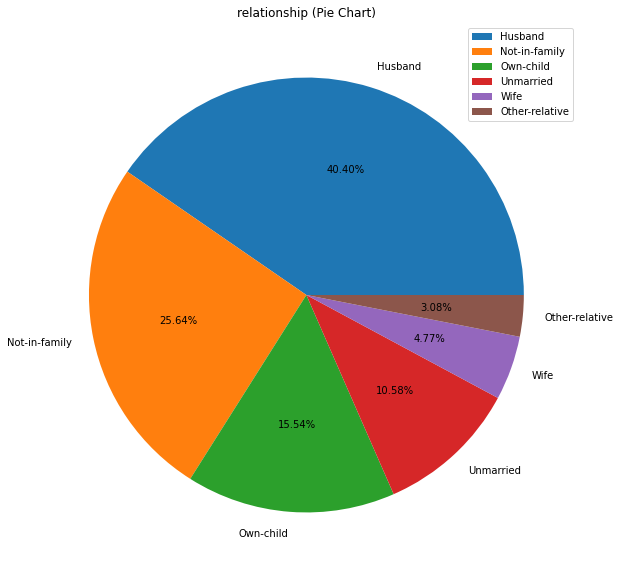

In [357]:
fig, ax = plt.subplots(figsize=(18,10))
plt.pie(train_copy['relationship'].value_counts(), labels=train_copy['relationship'].value_counts().index, autopct='%1.2f%%')
plt.title('relationship (Pie Chart)')
plt.legend(loc='upper right')
plt.show()

In [358]:
# TODO: relationship is highly correlated with Marital status. we might need to drop this feature.

### 3.4.9 Race

In [359]:
train_copy['race'].dtype

dtype('O')

In [360]:
train_copy['race'].isnull().sum()

0

In [361]:
train_copy['race'].head()

0    White
1    White
2    White
3    White
4    White
Name: race, dtype: object

In [362]:
value_cnt_norm_cal(train_copy,'race')

Count  Frequency (%)
White               30653         85.422
Black                3440          9.586
Asian-Pac-Islander   1118          3.116
Amer-Indian-Eskimo    355          0.989
Other                 318          0.886

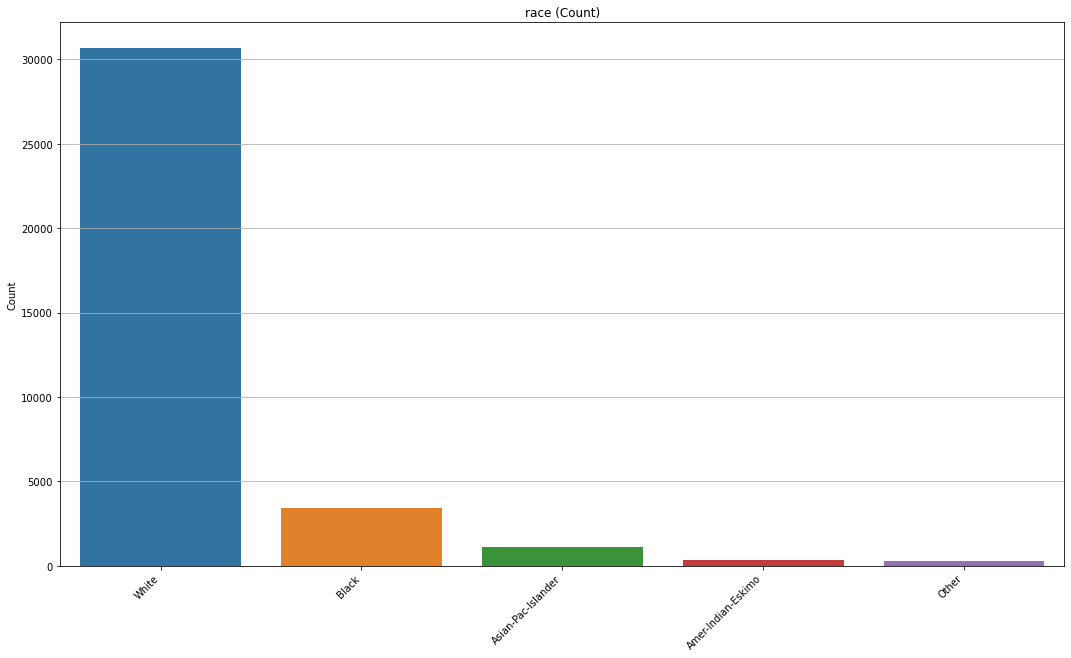

In [363]:
fig, ax = plt.subplots(figsize=(18,10))
sns.barplot(x=value_cnt_norm_cal(train_copy,'race').index, y=value_cnt_norm_cal(train_copy,'race')['Count'])
plt.title('race (Count)')
plt.grid(True,axis='y')
plt.xticks(rotation=45,ha='right')
plt.show()

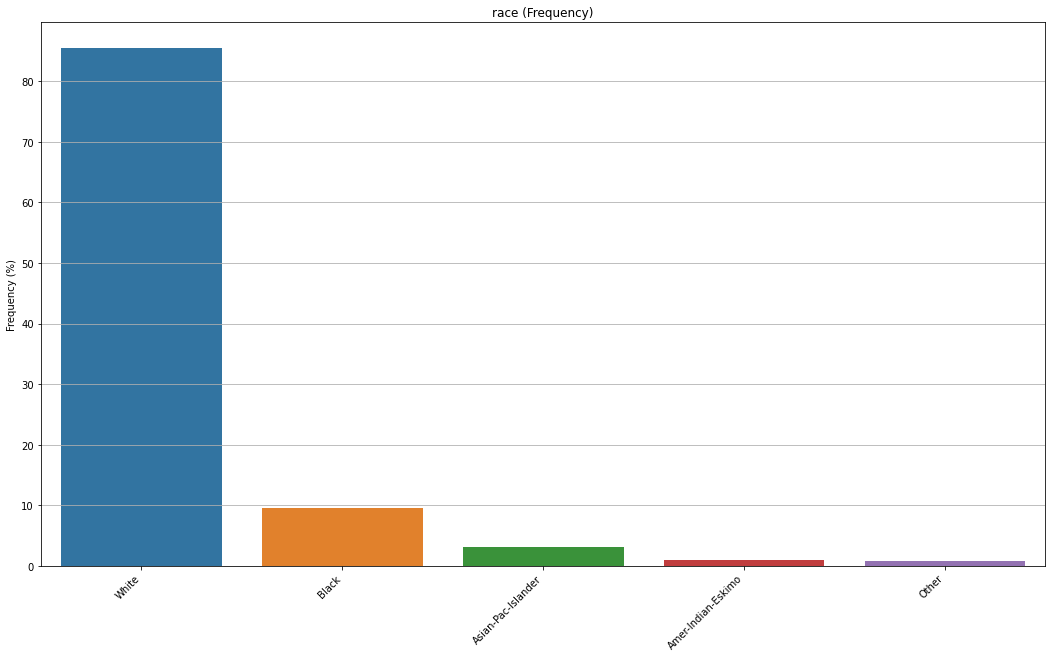

In [364]:
fig, ax = plt.subplots(figsize=(18,10))
sns.barplot(x=value_cnt_norm_cal(train_copy,'race').index, y=value_cnt_norm_cal(train_copy,'race')['Frequency (%)'])
plt.title('race (Frequency)')
plt.grid(True,axis='y')
plt.xticks(rotation=45,ha='right')
plt.show()

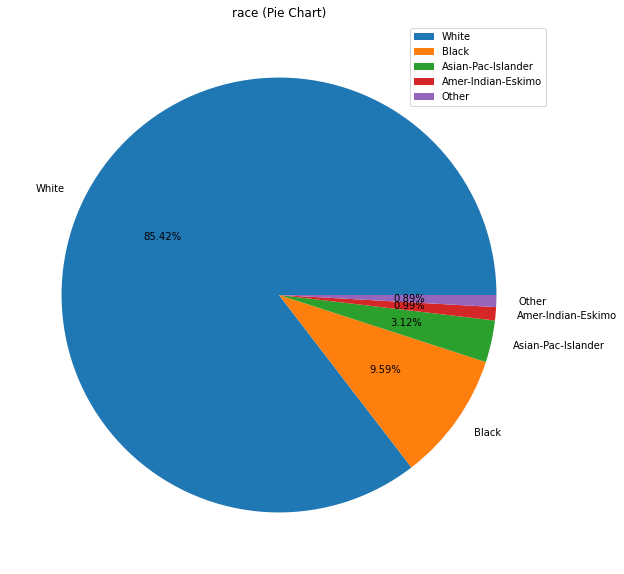

In [365]:
fig, ax = plt.subplots(figsize=(18,10))
plt.pie(train_copy['race'].value_counts(), labels=train_copy['race'].value_counts().index, autopct='%1.2f%%')
plt.title('race (Pie Chart)')
plt.legend(loc='upper right')
plt.show()

In [366]:
# TODO: Race might influence on the salary. will keep it

### 3.4.10 Gender

In [367]:
train_copy['gender'].dtype

dtype('O')

In [368]:
train_copy['race'].isnull().sum()

0

In [369]:
value_cnt_norm_cal(train_copy,'gender')

Count  Frequency (%)
Male    23975         66.813
Female  11909         33.187

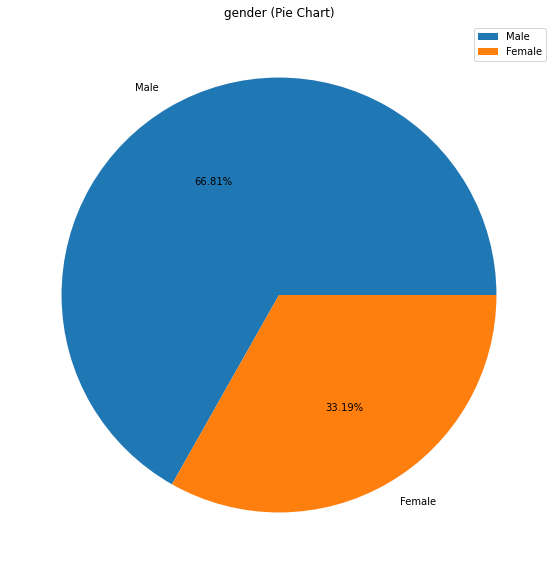

In [370]:
fig, ax = plt.subplots(figsize=(18,10))
plt.pie(train_copy['gender'].value_counts(), labels=train_copy['gender'].value_counts().index, autopct='%1.2f%%')
plt.title('gender (Pie Chart)')
plt.legend(loc='upper right')
plt.show()

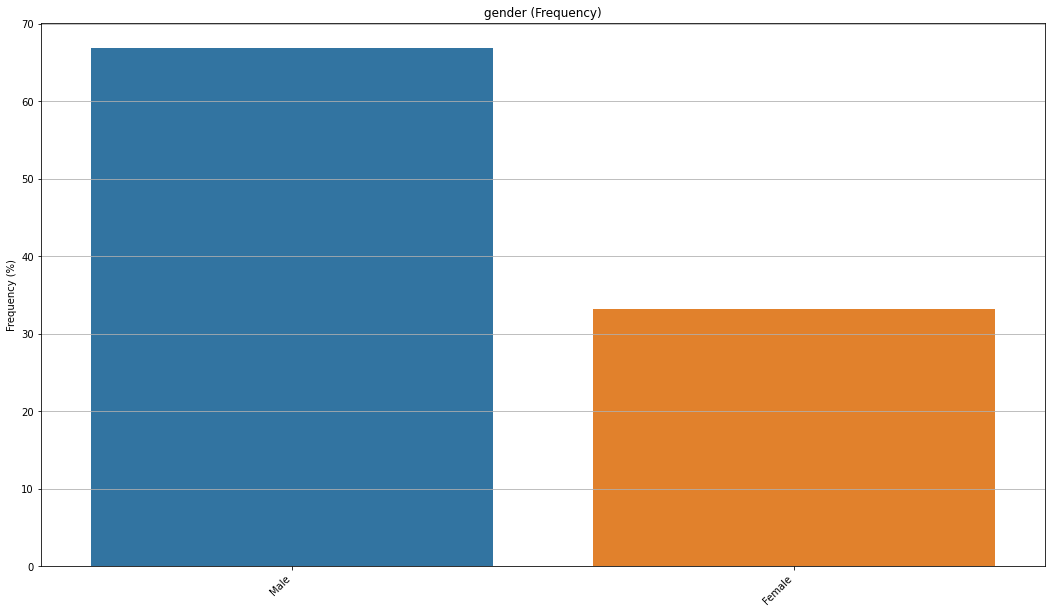

In [371]:
fig, ax = plt.subplots(figsize=(18,10))
sns.barplot(x=value_cnt_norm_cal(train_copy,'gender').index, y=value_cnt_norm_cal(train_copy,'gender')['Frequency (%)'])
plt.title('gender (Frequency)')
plt.grid(True,axis='y')
plt.xticks(rotation=45,ha='right')
plt.show()

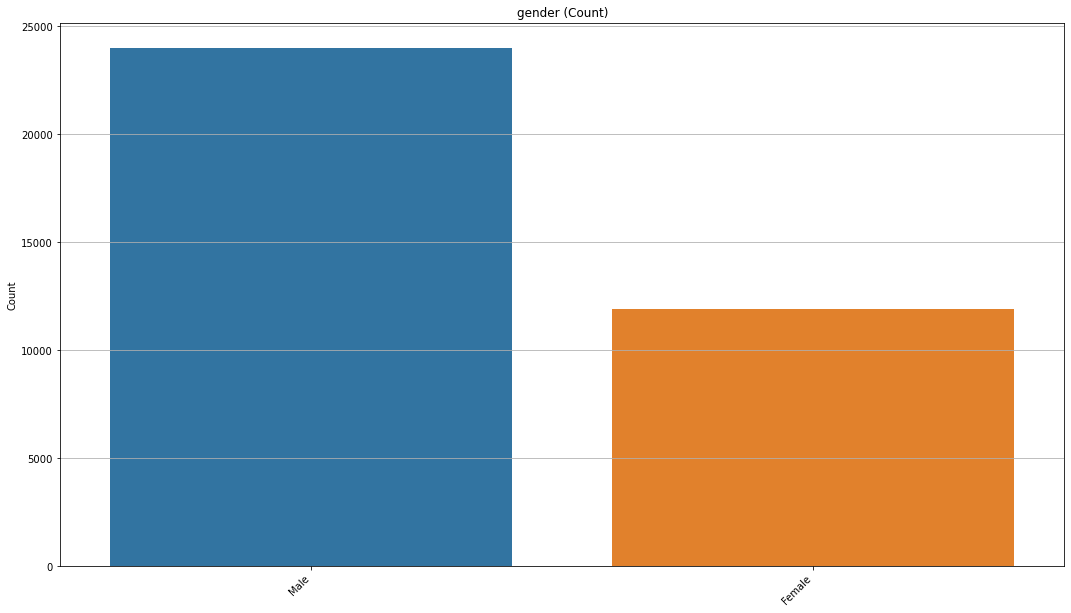

In [372]:
fig, ax = plt.subplots(figsize=(18,10))
sns.barplot(x=value_cnt_norm_cal(train_copy,'gender').index, y=value_cnt_norm_cal(train_copy,'gender')['Count'])
plt.title('gender (Count)')
plt.grid(True,axis='y')
plt.xticks(rotation=45,ha='right')
plt.show()

In [373]:
# TODO: Gender might influence on the salary. will keep it

### 3.4.11 capital gain

In [374]:
train_copy['capital-gain'].dtype

dtype('int64')

In [375]:
train_copy['capital-gain'].describe()

count   35884.000
mean     1083.889
std      7499.992
min         0.000
25%         0.000
50%         0.000
75%         0.000
max     99999.000
Name: capital-gain, dtype: float64

In [376]:
train_copy['capital-gain'].isnull().sum()

0

In [377]:
train_copy['capital-gain'].value_counts()

0        32944
15024      375
7688       302
7298       270
99999      182
         ...  
1111         1
6612         1
18481        1
1731         1
1424         1
Name: capital-gain, Length: 120, dtype: int64

In [378]:
train_copy['capital-gain'].shape

(35884,)

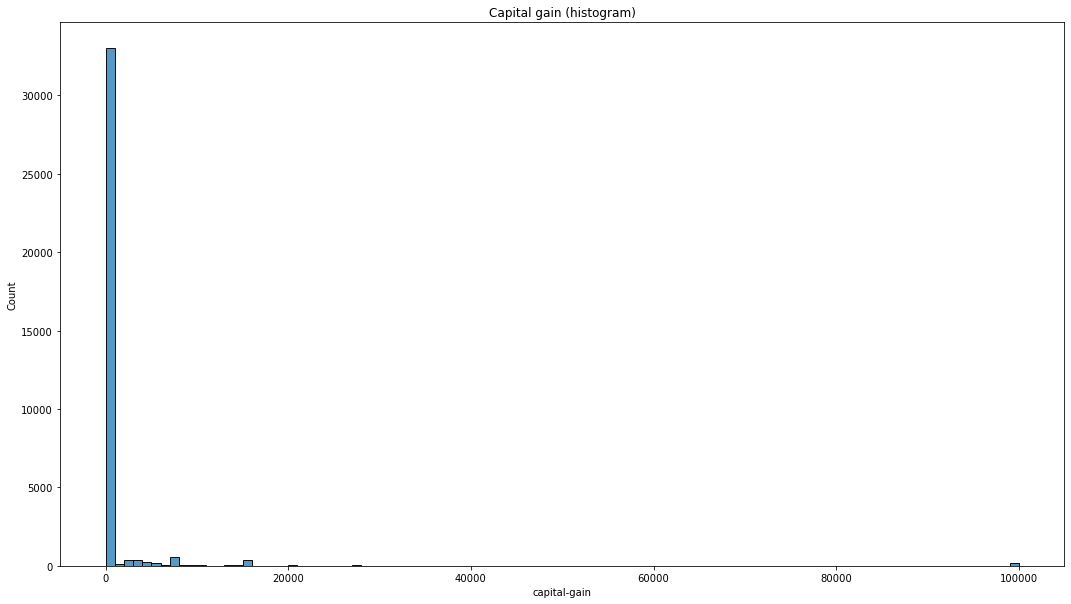

In [379]:
fig, ax = plt.subplots(figsize=(18,10))
sns.histplot(train_copy['capital-gain'],bins=100)
plt.title('Capital gain (histogram)')
plt.show()

In [380]:
# TODO: Capital gain is very skewed and contains a lot of zeros. we might need to drop this feature.

### 3.4.12 capital loss

In [381]:
train_copy['capital-loss'].dtype

dtype('int64')

In [382]:
train_copy['capital-loss'].describe()

count   35884.000
mean       89.856
std       408.524
min         0.000
25%         0.000
50%         0.000
75%         0.000
max      4356.000
Name: capital-loss, dtype: float64

In [383]:
train_copy['capital-loss'].isnull().sum()

0

In [384]:
train_copy['capital-loss'].value_counts()

0       34163
1902      221
1977      190
1887      170
2415       54
        ...  
1816        1
2282        1
1421        1
1911        1
2163        1
Name: capital-loss, Length: 97, dtype: int64

In [385]:
train_copy['capital-loss'].shape

(35884,)

In [386]:
value_cnt_norm_cal(train_copy,'capital-loss')

Count  Frequency (%)
0     34163         95.204
1902    221          0.616
1977    190          0.529
1887    170          0.474
2415     54          0.150
...     ...            ...
1816      1          0.003
2282      1          0.003
1421      1          0.003
1911      1          0.003
2163      1          0.003

[97 rows x 2 columns]

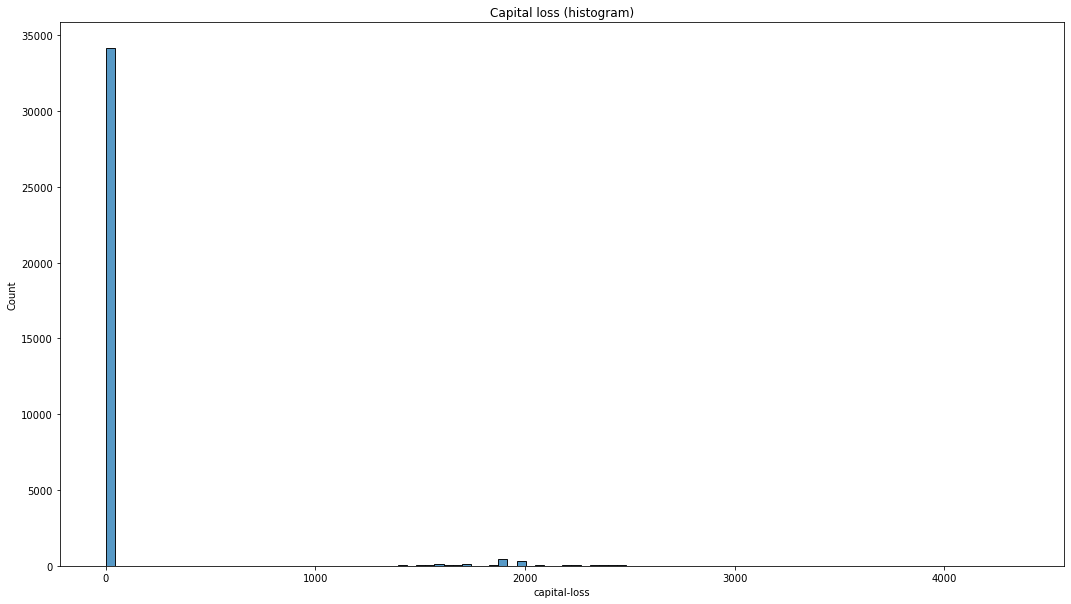

In [387]:
fig, ax = plt.subplots(figsize=(18,10))
sns.histplot(train_copy['capital-loss'],bins=100)
plt.title('Capital loss (histogram)')
plt.show()

In [388]:
# TODO: Capital loss is very skewed and contains a lot of zeros. we might need to drop this feature.

### 3.4.13 Hours per week

In [389]:
train_copy['hours-per-week'].dtype

dtype('int64')

In [390]:
train_copy['hours-per-week'].describe()

count   35884.000
mean       40.437
std        12.348
min         1.000
25%        40.000
50%        40.000
75%        45.000
max        99.000
Name: hours-per-week, dtype: float64

In [391]:
value_cnt_norm_cal(train_copy,'hours-per-week')

Count  Frequency (%)
40  16731         46.625
50   3132          8.728
45   2009          5.599
60   1597          4.450
35   1440          4.013
..    ...            ...
97      1          0.003
94      1          0.003
88      1          0.003
82      1          0.003
79      1          0.003

[95 rows x 2 columns]

In [392]:
train_copy['hours-per-week'].isnull().sum()

0

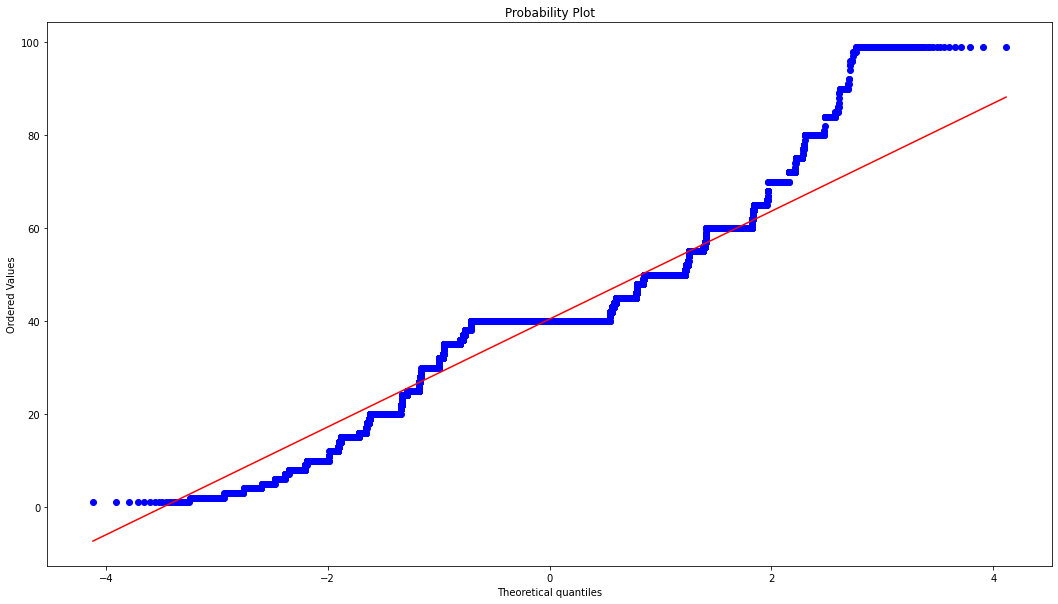

In [393]:
#checking if hours-per-week is normally distributed
fig, ax = plt.subplots(figsize=(18,10))
probplot(train_copy['hours-per-week'], dist="norm", plot=ax)
plt.show()

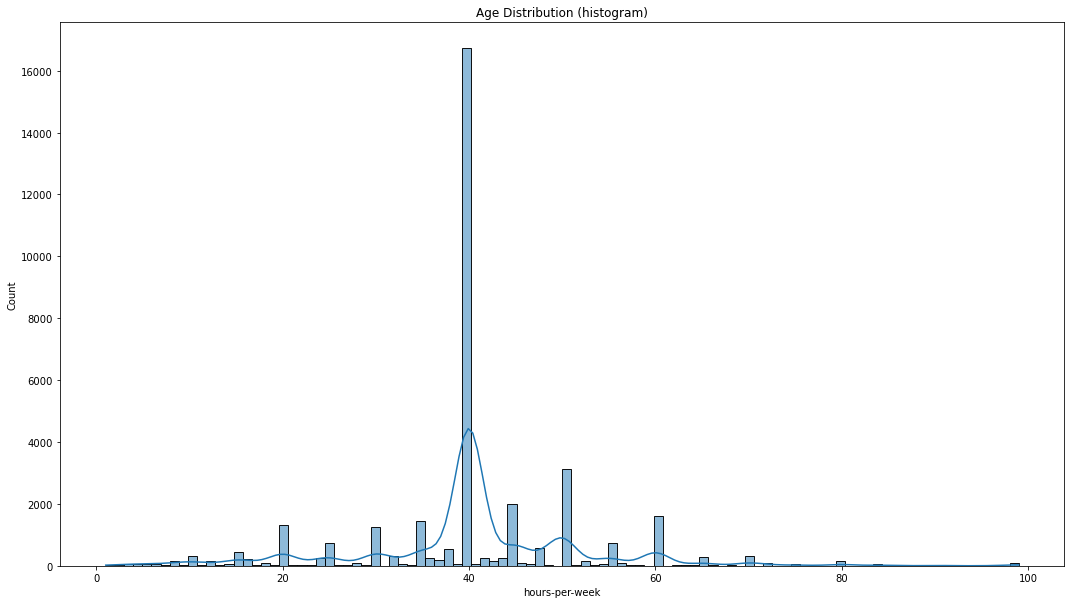

In [394]:
fig, ax = plt.subplots(figsize=(18,10))
sns.histplot(train_copy['hours-per-week'],bins=100,kde=True)
plt.title('Age Distribution (histogram)')
plt.show()

In [395]:
# TODO: Hours per week might be useful. will keep it

### 3.4.14 Native country

In [396]:
train_copy['native-country'].dtype

dtype('O')

In [397]:
train_copy['native-country'].isnull().sum()

623

In [398]:
value_cnt_norm_cal(train_copy,'native-country')

Count  Frequency (%)
United-States               32182         91.268
Mexico                        725          2.056
Philippines                   235          0.666
Germany                       157          0.445
Puerto-Rico                   140          0.397
Canada                        133          0.377
El-Salvador                   123          0.349
India                         109          0.309
England                       101          0.286
Cuba                           95          0.269
China                          91          0.258
Jamaica                        80          0.227
South korea                    77          0.218
Dominican-Republic             75          0.213
Italy                          70          0.199
Guatemala                      70          0.199
Japan                          67          0.190
Columbia                       60          0.170
Vietnam                        60          0.170
Poland                         59          0.167
Haiti                          57          0.162
Portugal                       49          0.139
Taiwan                         44          0.125
Nicaragua                      41          0.116
Iran                           37          0.105
Greece                         36          0.102
Peru                           34          0.096
Ecuador                        32          0.091
France                         28          0.079
Hong-Kong                      26          0.074
Thailand                       24          0.068
Ireland                        24          0.068
Cambodia                       21          0.060
Trinadad&Tobago                18          0.051
Yugoslavia                     17          0.048
Outlying-US(Guam-USVI-etc)     17          0.048
Honduras                       17          0.048
Laos                           16          0.045
Hungary                        13          0.037
Netherlands                     1          0.003

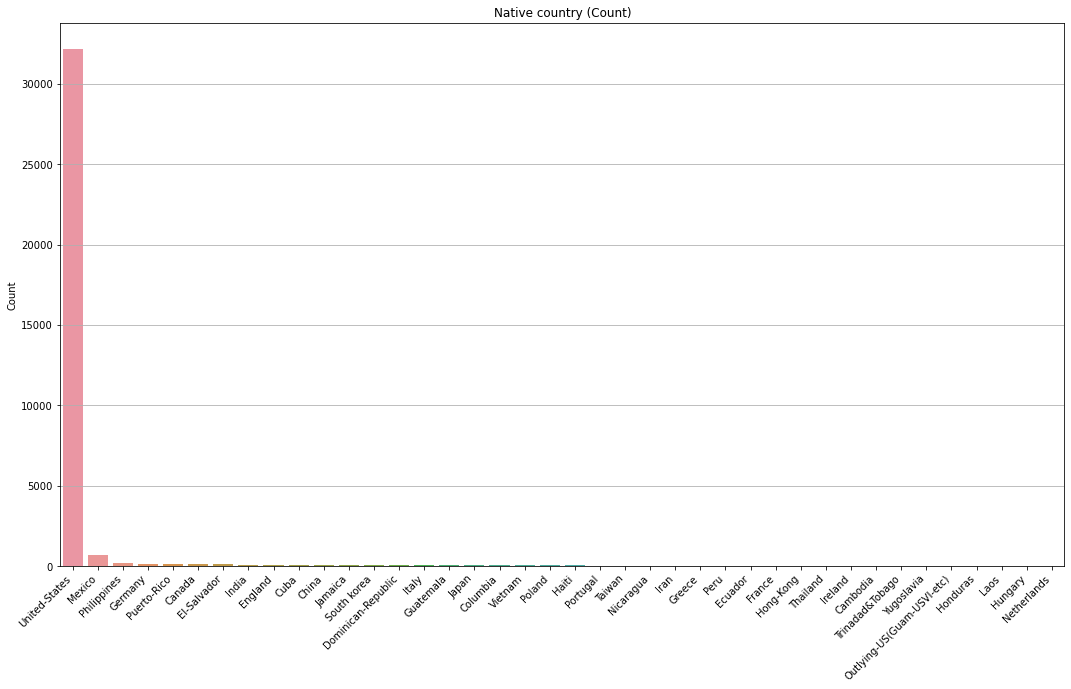

In [399]:
fig, ax = plt.subplots(figsize=(18,10))
sns.barplot(x=value_cnt_norm_cal(train_copy,'native-country').index, y=value_cnt_norm_cal(train_copy,'native-country')['Count'])
plt.title('Native country (Count)')
plt.grid(True,axis='y')
plt.xticks(rotation=45,ha='right')
plt.show()

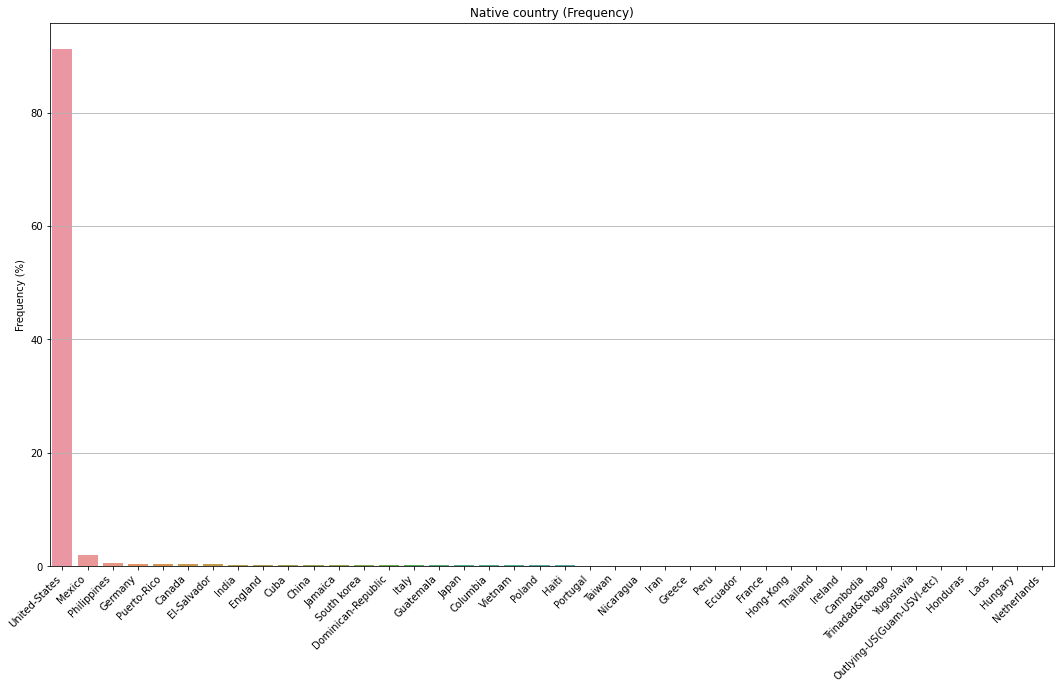

In [400]:
fig, ax = plt.subplots(figsize=(18,10))
sns.barplot(x=value_cnt_norm_cal(train_copy,'native-country').index, y=value_cnt_norm_cal(train_copy,'native-country')['Frequency (%)'])
plt.title('Native country (Frequency)')
plt.grid(True,axis='y')
plt.xticks(rotation=45,ha='right')
plt.show()

In [401]:
# TODO: Native country might be useful but most of the datapoint represent United States. we might need to ingore the other countries.

### 3.4.15 Income > 50 K

In [402]:
train_copy['income_>50K'].dtype

dtype('float64')

In [403]:
train_copy['income_>50K'].isnull().sum()

713

In [404]:
value_cnt_norm_cal(train_copy,'income_>50K')

Count  Frequency (%)
0.000  26744         76.040
1.000   8427         23.960

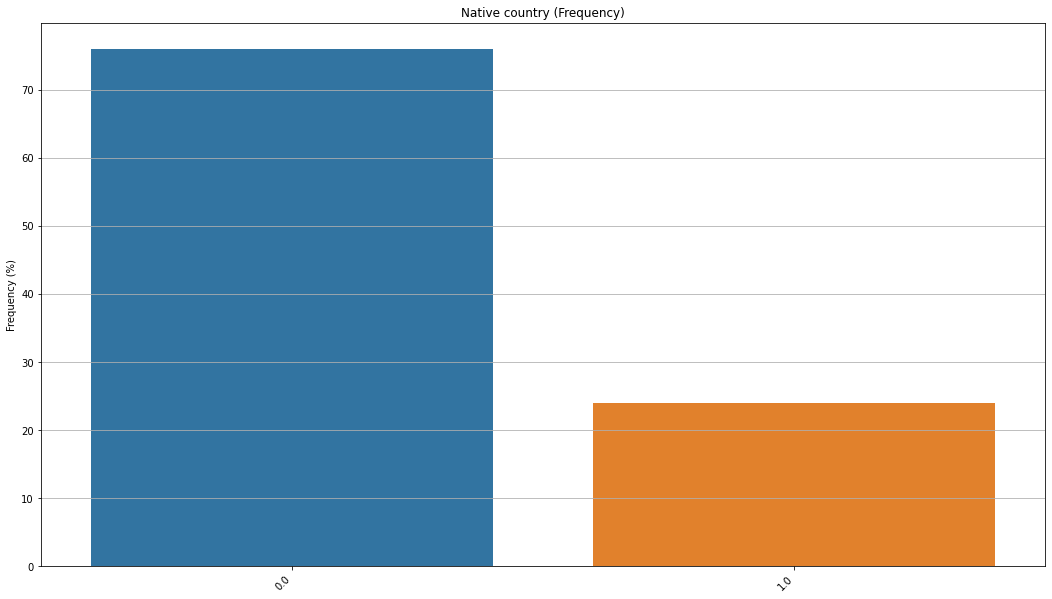

In [405]:
fig, ax = plt.subplots(figsize=(18,10))
sns.barplot(x=value_cnt_norm_cal(train_copy,'income_>50K').index, y=value_cnt_norm_cal(train_copy,'income_>50K')['Frequency (%)'])
plt.title('Native country (Frequency)')
plt.grid(True,axis='y')
plt.xticks(rotation=45,ha='right')
plt.show()


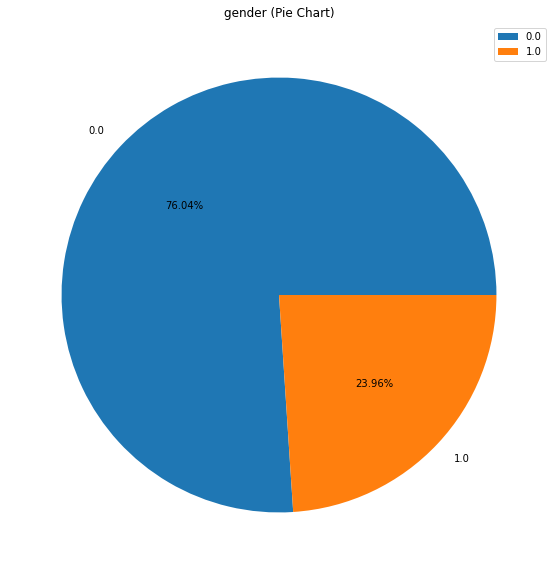

In [406]:
fig, ax = plt.subplots(figsize=(18,10))
plt.pie(train_copy['income_>50K'].value_counts(), labels=train_copy['income_>50K'].value_counts().index, autopct='%1.2f%%')
plt.title('gender (Pie Chart)')
plt.legend(loc='upper right')
plt.show()

In [407]:
# TODO: Our target is imbalance, we will need to oversample before training the model

## 3.5 For supervised learning tasks, identify the target attribute(s).

Tager attribute is the income > 50K

## 3.6 Visualize the data.

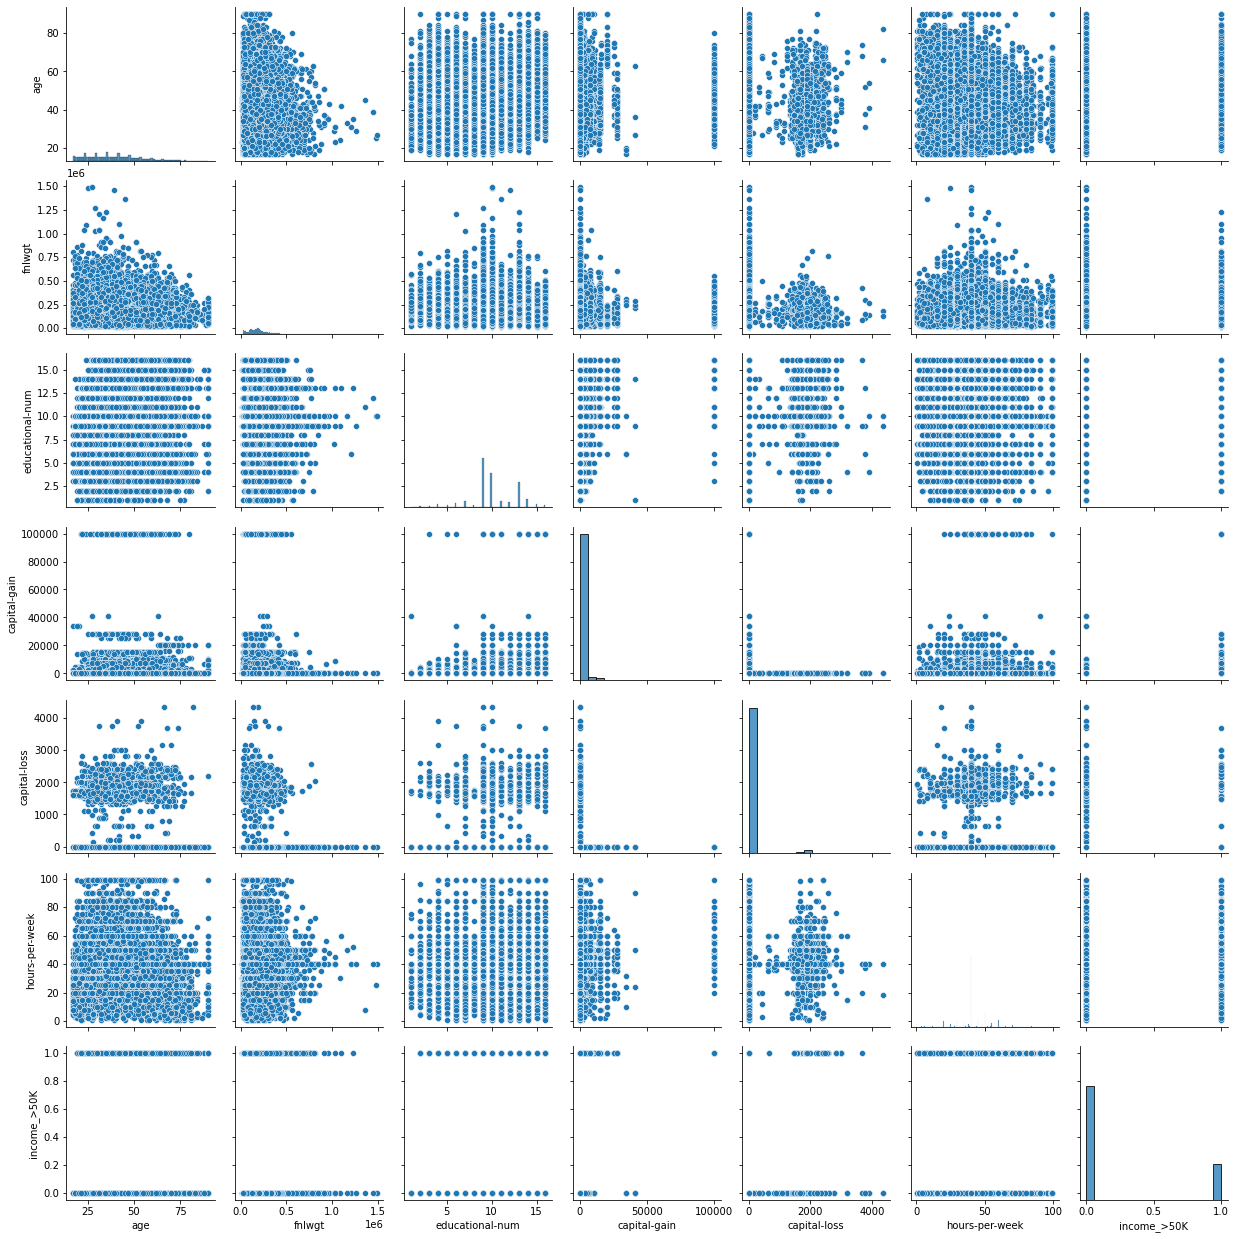

In [408]:
sns.pairplot(train_copy)
plt.show()

## 3.7 Study the pairwise interactions and correlations between attributes.

### 3.7.1 Age vs hours per week (Numerical vs Numerical feature)

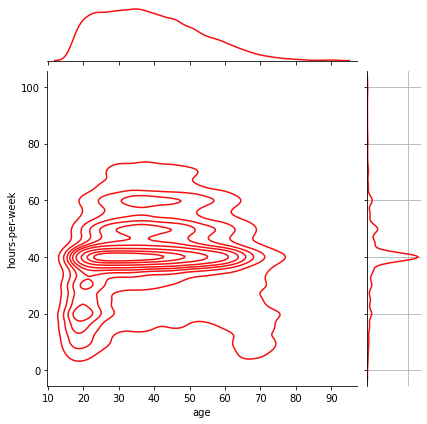

In [409]:
sns.jointplot(x='age', y='hours-per-week', data=train_copy, kind="kde", color="#f50f0f")
plt.grid()
plt.show()

### 3.7.2 Age vs educational number (Numerical vs Numerical feature)

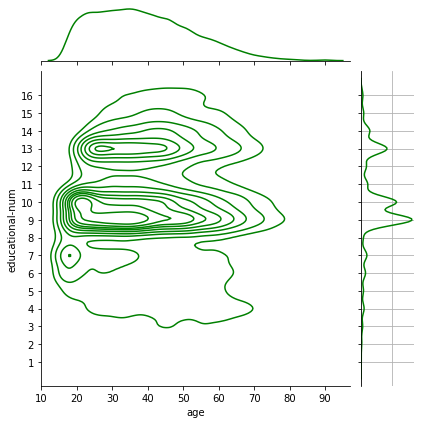

In [410]:
sns.jointplot(x='age', y='educational-num', data=train_copy, kind="kde", color="g")
plt.yticks(np.arange(1, train_copy['educational-num'].nunique()+1, 1))
plt.grid()
plt.show()

In [411]:
education_education_num_relation = pd.DataFrame(train_copy[['education','educational-num']].value_counts()).sort_values(by=['educational-num'], ascending=True).drop([0],axis=1)

In [412]:
education_education_num_relation

Empty DataFrame
Columns: []
Index: [(Preschool, 1), (1st-4th, 2), (5th-6th, 3), (7th-8th, 4), (9th, 5), (10th, 6), (11th, 7), (12th, 8), (HS-grad, 9), (Some-college, 10), (Assoc-voc, 11), (Assoc-acdm, 12), (Bachelors, 13), (Masters, 14), (Prof-school, 15), (Doctorate, 16)]

### 3.7.3 Educational-num vs hours-per-week (Numerical vs Numerical feature)

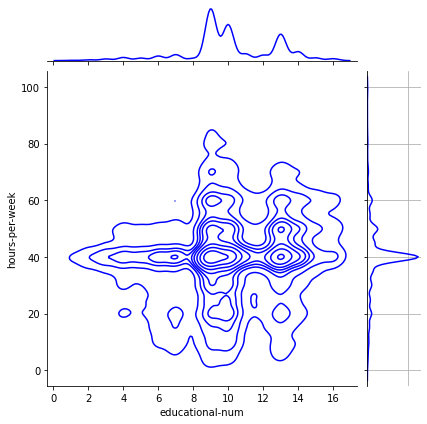

In [413]:
sns.jointplot(x='educational-num', y='hours-per-week', data=train_copy, kind="kde", color="b")
plt.grid()

### 3.7.4 Educational-num vs age (Numerical vs Numerical feature)

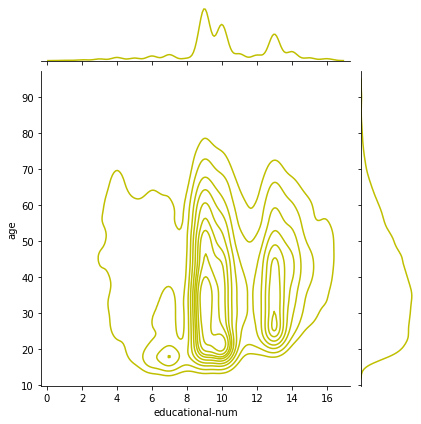

In [414]:
sns.jointplot(x='educational-num', y='age', data=train_copy, kind="kde", color="y")
plt.show()

### 3.7.5 Chi2 test for all the the categorical features (Categorical vs Categorical feature)

In [415]:
def chi2_test(feature_1,feature_2,show_contingency_table=False):
    # creating a cross tabulation of the two features
    feat_1_2_crosstab = pd.crosstab(train_copy[feature_1], train_copy[feature_2])
    stat, p, dof, cont_table = chi2_contingency(feat_1_2_crosstab)
    cont_table_df = pd.DataFrame(cont_table, index=feat_1_2_crosstab.index, columns=feat_1_2_crosstab.columns)
    # toggling the boolean to show the contingency table
    if show_contingency_table:
        print(cont_table_df)
    print('\n')
    prob = 0.95
    critical = chi2.ppf(prob, dof)
    print('probability=%.3f, critical=%.3f, stat=%.3f' % (prob, critical, stat))
    if abs(stat) >= critical:
        print('Dependent (reject H0)')
    else:
        print('Independent (fail to reject H0)')
    print('\n')
    # interpret p-value
    alpha = 1.0 - prob
    print('significance=%.3f, p=%.3f' % (alpha, p))
    if p <= alpha:
        print('Dependent (reject H0)')
    else:
        print('Independent (fail to reject H0)')
    # Different implementation of chi2 test

    # df_ft_1 = df[feature_1].dropna(axis=0, how='any')
    # df_ft_2 = df[feature_2].dropna(axis=0, how='any')
    # data_crosstab = pd.crosstab(df_ft_1,df_ft_2,margins=True, margins_name="Total")

    # # significance level
    # alpha = 0.05

    # Calculation of Chisquare test statistics
    # chi_square = 0
    # rows = df_ft_1.unique()
    # columns = df_ft_2.unique()
    # for i in columns:
    #     for j in rows:
    #         O = data_crosstab[i][j]
    #         E = data_crosstab[i]['Total'] * data_crosstab['Total'][j] / data_crosstab['Total']['Total']
    #         chi_square += (O-E)**2/E

    # # The p-value approach
    # print("Approach 1: The p-value approach to hypothesis testing in the decision rule")
    # p_value = 1 - norm.cdf(chi_square, (len(rows)-1)*(len(columns)-1))
    # conclusion = "Failed to reject the null hypothesis."
    # if p_value <= alpha:
    #     conclusion = "Null Hypothesis is rejected."
    # print("chisquare-score is:", chi_square, " and p value is:", p_value)
    # print(conclusion)
    # # The critical value approach
    # print("\n--------------------------------------------------------------------------------------")
    # print("Approach 2: The critical value approach to hypothesis testing in the decision rule")
    # critical_value = chi2.ppf(1-alpha, (len(rows)-1)*(len(columns)-1))
    # conclusion = "Failed to reject the null hypothesis."
    # if chi_square > critical_value:
    #     conclusion = "Null Hypothesis is rejected."
    # print("chisquare-score is:", chi_square, " and p value is:", critical_value)
    # print(conclusion)

In [416]:
all_cat_features = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'gender', 'native-country', 'income_>50K']

In [417]:
for i in all_cat_features:
    for j in all_cat_features:
        chi2_test(i,j)



probability=0.950, critical=66.339, stat=237195.000
Dependent (reject H0)


significance=0.050, p=0.000
Dependent (reject H0)


probability=0.950, critical=129.918, stat=2534.744
Dependent (reject H0)


significance=0.050, p=0.000
Dependent (reject H0)


probability=0.950, critical=58.124, stat=1258.369
Dependent (reject H0)


significance=0.050, p=0.000
Dependent (reject H0)


probability=0.950, critical=99.617, stat=9278.642
Dependent (reject H0)


significance=0.050, p=0.000
Dependent (reject H0)


probability=0.950, critical=49.802, stat=1362.874
Dependent (reject H0)


significance=0.050, p=0.000
Dependent (reject H0)


probability=0.950, critical=41.337, stat=503.455
Dependent (reject H0)


significance=0.050, p=0.000
Dependent (reject H0)


probability=0.950, critical=14.067, stat=686.012
Dependent (reject H0)


significance=0.050, p=0.000
Dependent (reject H0)


probability=0.950, critical=312.538, stat=529.540
Dependent (reject H0)


significance=0.050, p=0.000
Dependent (re

### 3.7.6 ANOVA test of age vs the rest of categoricals features (Numerical vs continuous feature)

In [418]:
all_cat_features

['workclass',
 'education',
 'marital-status',
 'occupation',
 'relationship',
 'race',
 'gender',
 'native-country',
 'income_>50K']

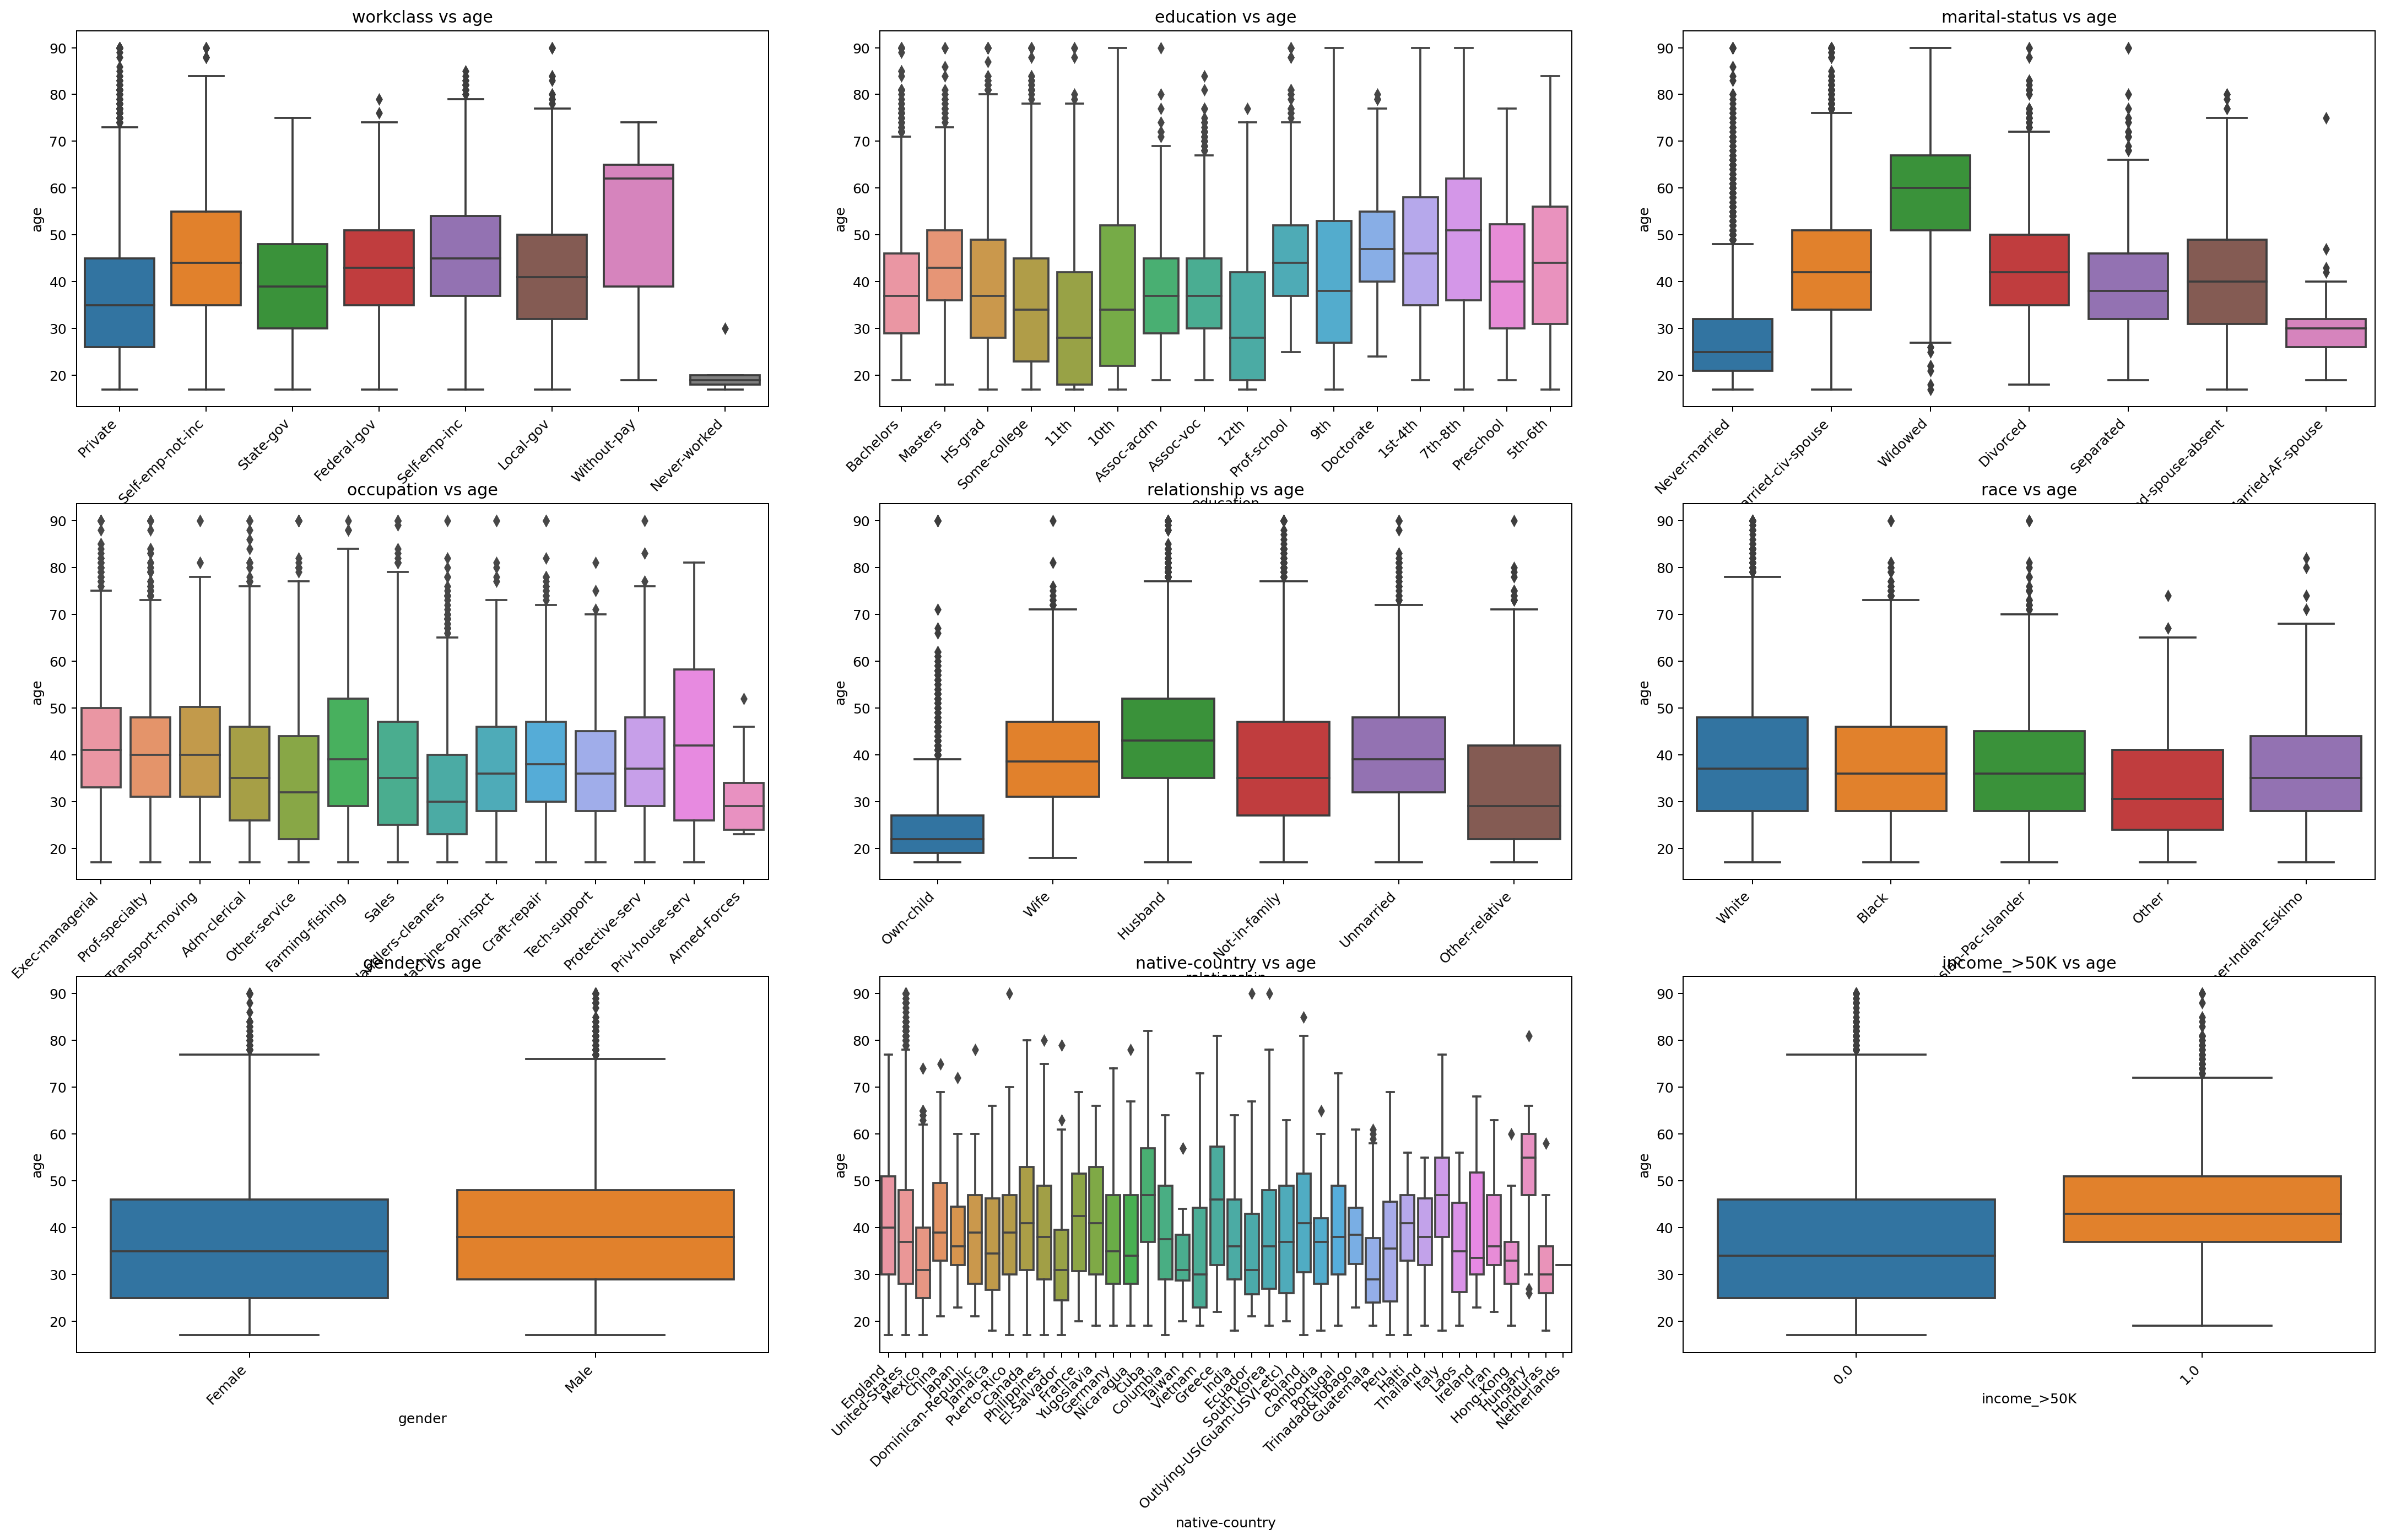

In [419]:
fig, axes = plt.subplots(3,3,figsize=(25,15),dpi=180)
fig.tight_layout(pad=5.0)

for cat_ft_count, ax in enumerate(axes):
    for row_count in range(3):
        for col_count in range(3):
            sns.boxplot(ax=axes[row_count,col_count],x=train_copy[all_cat_features[cat_ft_count]],y=train_copy['age'])
            axes[row_count,col_count].set_title(all_cat_features[cat_ft_count] + " vs age")
            plt.sca(axes[row_count,col_count])
            plt.xticks(rotation=45,ha='right')
            cat_ft_count += 1
    break

### 3.7.7 Correlation between features

In [420]:
train_copy_corr = train_copy.corr()

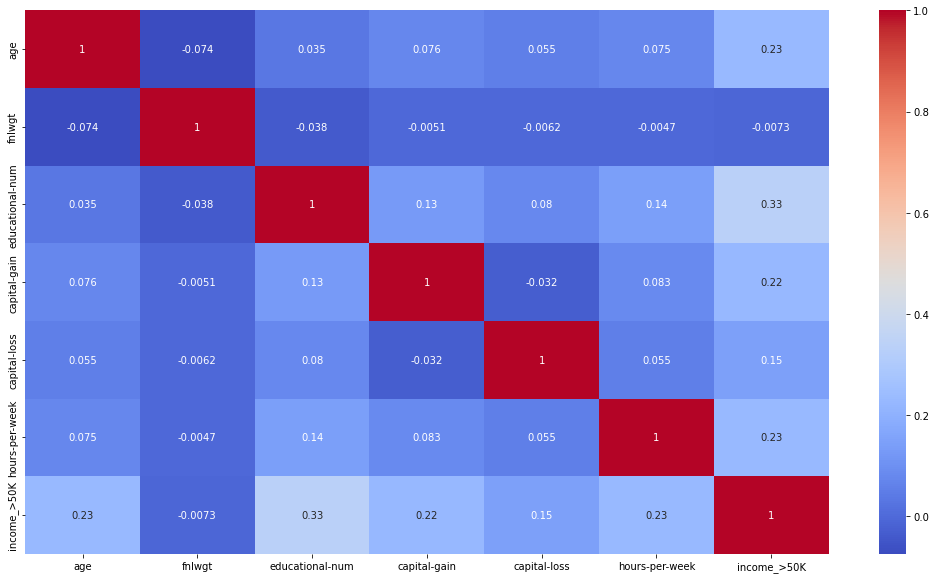

In [421]:
fig, ax = plt.subplots(figsize=(18,10))
sns.heatmap(train_copy_corr, annot=True, cmap='coolwarm')
plt.show()

In [422]:
mask = np.zeros_like(train_copy_corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True
train_copy_corr[mask] = np.nan
(train_copy_corr
 .style
 .background_gradient(cmap='bwr', axis=None, vmin=-1, vmax=1)
 .highlight_null(null_color='#f1f1f1')
)

## 3.8 Study how you would solve the problem manually.

I would look at the correlation between the features and the target variable. the strongest correlation with the target variable is the age, educational-num, capital-gain and hours-per-week.

## 3.9 Identify the promising transformations you may want to apply.

Age:
- Drop outliers
- Min Max Scaling
- Fix skewness

Workclass:
- drop the feature because highly correlated with occupation with less information (To be done after running the model and seeing the feature importance method)
- one hot encoding

Fnwgt:
- drop the feature because there is no correlation with target

Education:
- One hot encoding

Education-num:
- drop the column(because we will use education feature)

Marital-status:
- One hot encoding
- Create a toggle that will use Marital-status, Relation or both to predict income

Occupation:
- One hot encoding
- Handle missing values

Relation:
- One hot encoding
- Create a toggle that will use Marital-status, Relation or both to predict income

Race:
- One hot encoding

Gender:
- One hot encoding

Capital gain:
- Fix skewness
- Min Max Scaling

Capital loss:
- Fix skewness
- Min Max Scaling

Hours per week:
- Min Max Scaling

Native country:
- Groupe countries into 3 GDP Categories (High, Medium, Low GDP)
- drop the feature because we have extracted the 3 GDP categories

GDP Category(extracted from the Native country):
- One hot encoding those categories

Income (Target):
- Fix imbalance data(SMOTE or oversampling)




## 3.10 Identify extra data that would be useful

In [423]:
# GDP data that will be used to group the countries by their GDP
# GDP data of countries in 1990
# Using 1990 data because the Train and test data is an old dataset. How do I know that? One of the country name is Yugoslavia which is no longer since the mid-1990's.
gdp_data = pd.read_csv('datasets/GDP.csv')

In [424]:
gdp_data.sort_values(by='1990' , inplace=True,ascending=False)

In [425]:
gdp_data.reset_index(inplace=True, drop=True)

In [426]:
gdp_data.rename(columns={'Country Name':'native-country','1990':'GDP_1990'},inplace=True)

In [427]:
gdp_data

native-country  GDP_1990
0                  Monaco 84303.880
1    United Arab Emirates 71359.170
2                  Brunei 54713.545
3           Liechtenstein 49373.610
4              Luxembourg 29664.795
..                    ...       ...
191           Afghanistan   292.000
192            Mozambique   244.601
193               Eritrea   147.000
194               Somalia   126.920
195              Cambodia   100.000

[196 rows x 2 columns]

In [428]:
def add_gdp_data(train_copy,test_copy,gdp_data):
        full_data_copy = pd.concat([train_copy,test_copy],ignore_index=True)
        gdp_group = []
        for idx in gdp_data.index:
            if idx <= 65:
                gdp_group.append('High GDP')
            elif idx >= 65 and idx <= 130:
                gdp_group.append('Medium GDP')
            else:
                gdp_group.append('Low GDP')

        # concatenate the gdp_data with the gdp_group list
        gdp_data = pd.concat([gdp_data.rename(columns={'country':'native-country'}), pd.Series(gdp_group, name='GDP Group')], axis=1)
        # we no longer need the GDP column, so let's drop it
        gdp_data.drop(['GDP_1990'],axis=1,inplace=True)

        # we need to merge the gdp_data with X dataframe
        full_data_copy = pd.merge(full_data_copy, gdp_data, on='native-country', how='left')
        # make income_>50K the last column
        new_col_order = [col for col in full_data_copy.columns if col != 'income_>50K'] + ['income_>50K']
        return full_data_copy[new_col_order]


In [429]:
full_data_copy = add_gdp_data(train_copy,test_copy,gdp_data)

In [430]:
train_copy, test_copy = data_split(full_data_copy,0.2)

## 3.11 Document what you have learned.

All the categorical features are highly correlated (category vs category) and the age and marital status, relationship are highly correlated (numerical vs continuous), finally target is highly correlated with the education, capital gain, age, hour-per-week (numerical vs numerical). 

# 4. Prepare the data for the model

## 4.1 Data cleaning

### 4.1.1 Fix or remove outliers

In [431]:
class OutlierHandler(BaseEstimator, TransformerMixin):
    def __init__(self,col_with_outliers = ['age']):
        self.col_with_outliers = col_with_outliers
    def fit(self,X,y=None):
        return self
    def transform(self,X,y=None):
        if (set(self.col_with_outliers).issubset(X.columns)):
            Q1 = X[self.col_with_outliers].quantile(.25)
            Q3 = X[self.col_with_outliers].quantile(.75)
            IQR = Q3 - Q1
            outlier_condition = (X[self.col_with_outliers] < (Q1 - 1.5 * IQR)) | (X[self.col_with_outliers] > (Q3 + 1.5 * IQR))
            index_to_keep = X[~outlier_condition.any(axis=1)].index
            return X.loc[index_to_keep]
        else:
            print("Columns not found")
            return X

### 4.1.2 Fill in missing values (e.g., with zero, mean, median...) or drop their rows (or columns).

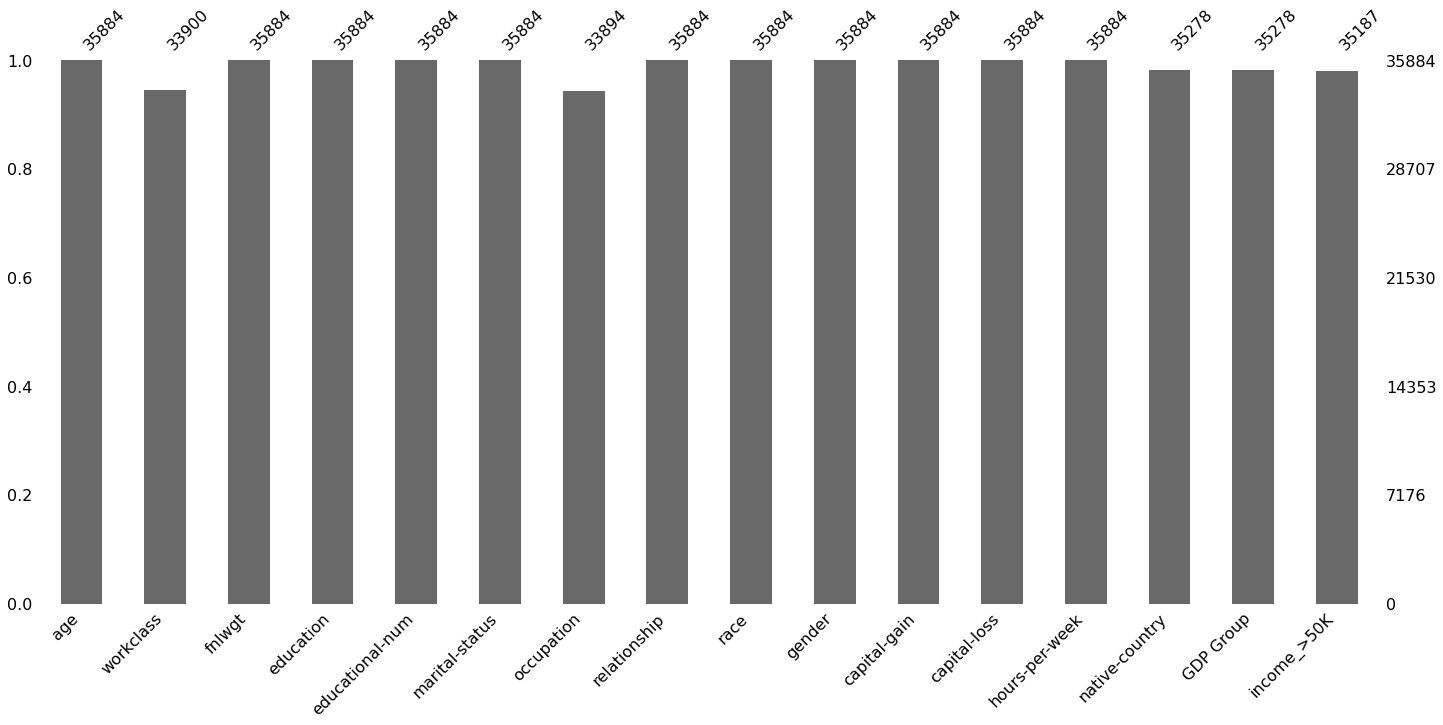

In [432]:
msno.bar(train_copy)
plt.show()

In [433]:
class MissingValHandler(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    def fit(self,X,y=None):
        return self
    def transform(self,X,y=None):
        # drop all the rows with missing values in X
        X.dropna(inplace=True)
        X.reset_index(inplace=True, drop=True)
        return X

## 4.2 Feature selection

In [434]:
# using the feature importance method from the estimator, drop those features that have a low importance.
# # drop_workclass will be called separately after running the model.
# # drop_native_country will be called separately after running extraction the GDP group column
# class FeatureToDrop(BaseEstimator,TransformerMixin):
#     # def __init__(self,feature_to_drop = {'fnlwgt':True,'educational-num':True,'native-country':False,'workclass':False,'occupation':False}):
#     #     self.feature_to_drop = feature_to_drop
#     def __init__(self):
#         self.feature_to_drop = ['fnlwgt','educational-num','native-country']
#     def fit(self,X,y=None):
#         return self
#     def transform(self,X,y=None):
#         # for cols_to_drop in self.feature_to_drop.keys():
#         #     if self.feature_to_drop[cols_to_drop] == True:
#         #         # the column with the keys that were changed to True while initializing the class will be added to the list
#         #         self.feature_to_drop_list.append(cols_to_drop)
#         if (set(self.feature_to_drop).issubset(X.columns)):
#             # drop the columns that were added to the list
#             X.drop(self.feature_to_drop,axis=1,inplace=True)
#             return X
#         else:
#             print('One or more columns to be dropped not found in the dataframe')
#             return X
# TODO: Implement a feature selection function that takes in the least predictive features for each model, drop them and retrain the models automatically.
def feature_to_drop(model_name,feat_list):
    # To be implemented
    pass


## 4.3 Feature Engineering and Transformation

In [435]:
# TODO: create a function that takes in the country and returns the 3 GDP categorories. This will be useful with the streamlit interface.

In [436]:
def get_gdp_group(country_name):
    # To be implemented
    pass

### 4.1.3.2 Skewness fixings

For more information, refere to [this post](https://medium.com/@TheDataGyan/day-8-data-transformation-skewness-normalization-and-much-more-4c144d370e55)

In [437]:
class SkewnessHandler(BaseEstimator, TransformerMixin):
    def __init__(self,col_with_skewness=['age','capital-gain','capital-loss']):
        self.col_with_skewness = col_with_skewness
    def fit(self,X,y=None):
        return self
    def transform(self,X,y=None):
        if (set(self.col_with_skewness).issubset(X.columns)):
            # Handle skewness with cubic root transformation
            X[self.col_with_skewness] = np.cbrt(X[self.col_with_skewness])
            return X
        else:
            print('One or more skewed columns are not found')
            return X

### 4.1.3.3 Oversampling with SMOTE

In [438]:
class OversampleSMOTE(BaseEstimator,TransformerMixin):
    def __init__(self, perform_oversampling = True):
        self.perform_oversampling = perform_oversampling
    def fit(self,X,y=None):
        return self
    def transform(self,X,y=None):
        # function to oversample the minority class
        if self.perform_oversampling:
            smote = SMOTE()
            X_bal, y_bal = smote.fit_resample(X.iloc[:,:-1],X.iloc[:,-1])
            X_y_bal = pd.concat([pd.DataFrame(X_bal),pd.DataFrame(y_bal)],axis=1)
            return X_y_bal
        else:
            print("No oversampling performed")
            return X

## 4.4 Feature scaling

Will be applied directly in the column transformer/pipeline because they are built in functions

## 4.5 Apply the column transformer and pipeline

In [439]:
def smote_pipeline_fuc(df):
    smote_pipeline = Pipeline([
        ('smote', OversampleSMOTE()) # default: perform_oversampling = True
    ])
    smote_pip_result = smote_pipeline.fit_transform(df)
    return smote_pip_result


In [440]:
def concat_fuc(df_ordinal_minmax, df_onehot, df_target):
    concat_df = pd.concat([df_ordinal_minmax, df_onehot, df_target], axis=1)
    return concat_df

In [441]:
def one_hot_enc_fuc(df):
    columns_to_one_hot_enc = ['race', 'gender', 'workclass', 'occupation','marital-status', 'relationship']
    one_hot_enc = OneHotEncoder()
    one_hot_enc.fit(df[columns_to_one_hot_enc])
    # get the result of the one hot encoding columns names
    cols_names_one_hot_enc = one_hot_enc.get_feature_names_out(columns_to_one_hot_enc)
    # change the array of the one hot encoding to a dataframe with the column names
    one_hot_result_with_names_col = pd.DataFrame(one_hot_enc.transform(df[columns_to_one_hot_enc]).toarray(),columns=cols_names_one_hot_enc)
    return one_hot_result_with_names_col

In [442]:
def ordinal_minmax_scaler_fuc(df):
    columns_to_ordinal_enc = ['education', 'GDP Group']
    columns_to_scale = ['age', 'capital-gain', 'capital-loss', 'hours-per-week']
    col_transformer = ColumnTransformer([
    ('Ordinal encoder',OrdinalEncoder(),columns_to_ordinal_enc), # ordinal encoding for education and GDP Group because they are ranked
    ('Min max scaler',MinMaxScaler(),columns_to_scale)]) # scaling for age, capital-gain, capital-loss, hours-per-week
    ordinal_minmax_scaler_result = col_transformer.fit_transform(df)
    ordinal_minmax_scaler_result_with_names_col = pd.DataFrame(ordinal_minmax_scaler_result,columns=columns_to_ordinal_enc+columns_to_scale)
    return ordinal_minmax_scaler_result_with_names_col

In [443]:
def extract_target_col(df):
    target = df.iloc[:,-1].to_frame().reset_index(drop=True)
    return target

In [444]:
def initial_pipeline_fuc(df):
    init_pipeline = Pipeline([
        ('Missing values handler', MissingValHandler()), # drop missing values in the whole dataset
        ('Outliers handler', OutlierHandler()),
        ('Skewness handler', SkewnessHandler()), # columns with skewness are 'age','capital-gain','capital-loss'
    ])
    init_pip_result = init_pipeline.fit_transform(df)
    return init_pip_result

In [445]:
def full_pipeline_fuc(df):
    # initial pipeline
    init_pip_result = initial_pipeline_fuc(df)
    #extracting the target variable
    target = extract_target_col(init_pip_result)
    # column transformers to apply ordinal and minmax transformation on specific columns
    ordinal_minmax_result = ordinal_minmax_scaler_fuc(init_pip_result)
    #one hot encoding
    one_hot_enc_result = one_hot_enc_fuc(init_pip_result)
    # concat the result from the ordinal and minmax transformation and one hot encoding with the target variable
    encoded_concat_result = concat_fuc(ordinal_minmax_result,one_hot_enc_result,target)
    # balance the imbalance data with smote function
    smote_pip_result = smote_pipeline_fuc(encoded_concat_result)
    return smote_pip_result

In [446]:
train_copy.head(2)

age workclass  fnlwgt  education  educational-num      marital-status  \
0   44   Private  198282  Bachelors               13  Married-civ-spouse   
1   48   Private  125892  Bachelors               13  Married-civ-spouse   

        occupation relationship   race gender  capital-gain  capital-loss  \
0  Exec-managerial      Husband  White   Male         15024             0   
1     Tech-support      Husband  White   Male             0             0   

   hours-per-week native-country GDP Group  income_>50K  
0              60  United-States  High GDP        1.000  
1              40  United-States  High GDP        1.000

In [447]:
train_copy_prep = full_pipeline_fuc(train_copy)
train_copy_prep.shape
train_copy_prep.head(2)

education  GDP Group   age  capital-gain  capital-loss  hours-per-week  \
0      9.000      0.000 0.583         0.532         0.000           0.602   
1      9.000      0.000 0.646         0.000         0.000           0.398   

   race_Amer-Indian-Eskimo  race_Asian-Pac-Islander  race_Black  race_Other  \
0                    0.000                    0.000       0.000       0.000   
1                    0.000                    0.000       0.000       0.000   

   race_White  gender_Female  gender_Male  workclass_Federal-gov  \
0       1.000          0.000        1.000                  0.000   
1       1.000          0.000        1.000                  0.000   

   workclass_Local-gov  workclass_Private  workclass_Self-emp-inc  \
0                0.000              1.000                   0.000   
1                0.000              1.000                   0.000   

   workclass_Self-emp-not-inc  workclass_State-gov  workclass_Without-pay  \
0                       0.000                0.000                  0.000   
1                       0.000                0.000                  0.000   

   occupation_Adm-clerical  occupation_Armed-Forces  occupation_Craft-repair  \
0                    0.000                    0.000                    0.000   
1                    0.000                    0.000                    0.000   

   occupation_Exec-managerial  occupation_Farming-fishing  \
0                       1.000                       0.000   
1                       0.000                       0.000   

   occupation_Handlers-cleaners  occupation_Machine-op-inspct  \
0                         0.000                         0.000   
1                         0.000                         0.000   

   occupation_Other-service  occupation_Priv-house-serv  \
0                     0.000                       0.000   
1                     0.000                       0.000   

   occupation_Prof-specialty  occupation_Protective-serv  occupation_Sales  \
0                      0.000                       0.000             0.000   
1                      0.000                       0.000             0.000   

   occupation_Tech-support  occupation_Transport-moving  \
0                    0.000                        0.000   
1                    1.000                        0.000   

   marital-status_Divorced  marital-status_Married-AF-spouse  \
0                    0.000                             0.000   
1                    0.000                             0.000   

   marital-status_Married-civ-spouse  marital-status_Married-spouse-absent  \
0                              1.000                                 0.000   
1                              1.000                                 0.000   

   marital-status_Never-married  marital-status_Separated  \
0                         0.000                     0.000   
1                         0.000                     0.000   

   marital-status_Widowed  relationship_Husband  relationship_Not-in-family  \
0                   0.000                 1.000                       0.000   
1                   0.000                 1.000                       0.000   

   relationship_Other-relative  relationship_Own-child  \
0                        0.000                   0.000   
1                        0.000                   0.000   

   relationship_Unmarried  relationship_Wife  income_>50K  
0                   0.000              0.000        1.000  
1                   0.000              0.000        1.000

In [448]:
pd.set_option('display.max_columns', None)
train_copy_prep

education  GDP Group   age  capital-gain  capital-loss  hours-per-week  \
0          9.000      0.000 0.583         0.532         0.000           0.602   
1          9.000      0.000 0.646         0.000         0.000           0.398   
2         15.000      0.000 0.406         0.000         0.000           0.602   
3          9.000      0.000 0.566         0.532         0.000           0.500   
4          8.000      0.000 0.326         0.000         0.000           0.398   
...          ...        ...   ...           ...           ...             ...   
48663     11.000      0.000 0.535         0.000         0.000           0.602   
48664      9.000      0.000 0.744         1.000         0.000           0.500   
48665     11.000      0.000 0.636         0.000         0.274           0.451   
48666     15.000      0.000 0.799         0.421         0.000           0.420   
48667     11.000      0.000 0.465         0.000         0.000           0.602   

       race_Amer-Indian-Eskimo  race_Asian-Pac-Islander  race_Black  \
0                        0.000                    0.000       0.000   
1                        0.000                    0.000       0.000   
2                        0.000                    0.000       0.000   
3                        0.000                    0.000       0.000   
4                        0.000                    0.000       0.000   
...                        ...                      ...         ...   
48663                    0.000                    0.000       0.000   
48664                    0.000                    0.000       0.000   
48665                    0.000                    0.000       1.000   
48666                    0.000                    0.000       0.000   
48667                    0.000                    0.000       0.000   

       race_Other  race_White  gender_Female  gender_Male  \
0           0.000       1.000          0.000        1.000   
1           0.000       1.000          0.000        1.000   
2           0.000       1.000          0.000        1.000   
3           0.000       1.000          0.000        1.000   
4           0.000       1.000          0.000        1.000   
...           ...         ...            ...          ...   
48663       0.000       1.000          0.000        1.000   
48664       0.000       1.000          0.000        1.000   
48665       0.000       0.000          0.000        1.000   
48666       0.000       1.000          0.000        1.000   
48667       0.000       1.000          0.000        1.000   

       workclass_Federal-gov  workclass_Local-gov  workclass_Private  \
0                      0.000                0.000              1.000   
1                      0.000                0.000              1.000   
2                      0.000                0.000              1.000   
3                      0.000                0.000              1.000   
4                      0.000                0.000              1.000   
...                      ...                  ...                ...   
48663                  0.000                0.000              1.000   
48664                  0.000                0.000              1.000   
48665                  0.000                0.000              1.000   
48666                  0.000                0.000              1.000   
48667                  0.000                0.000              1.000   

       workclass_Self-emp-inc  workclass_Self-emp-not-inc  \
0                       0.000                       0.000   
1                       0.000                       0.000   
2                       0.000                       0.000   
3                       0.000                       0.000   
4                       0.000                       0.000   
...                       ...                         ...   
48663                   0.000                       0.000   
48664                   0.000                       0.000   
48665                   0.000     

In [449]:
test_copy_prep = full_pipeline_fuc(test_copy)
test_copy_prep.shape

(12218, 48)

In [450]:
X_train_copy_prep = train_copy_prep.iloc[:,:-1]
X_train_copy_prep.shape

(48668, 47)

In [451]:
y_train_copy_prep = train_copy_prep.iloc[:,-1]
y_train_copy_prep.shape

(48668,)

In [452]:
X_test_copy_prep = test_copy_prep.iloc[:,:-1]
X_test_copy_prep.shape

(12218, 47)

In [453]:
y_test_copy_prep = test_copy_prep.iloc[:,-1]
y_test_copy_prep.shape

(12218,)

# 5. Shorlist promising models

## 5.0 Functions to evaluate the model

In [469]:
def create_summary_table(summary_data):
    summary_table_col = [
        'Model name',
        'Precision score (Validation set)',
        'Recall score (Validation set)',
        'F1 score (Validation set)',
        'Accuracy score (Validation set)',
        'AUC score (Validation set)',
        'AUC score (Train set)',
        'Has overfit (AUC score (Train set) > AUC score (Validation set))',
        'Confusion matrix',
        'Roc auc curve',
        'Top 10 important features',
        'Top 10 useless features',
        'Top 10 important features plot',
        'Top 10 useless features plot',
        ]
    # print all the models summary and gave the width and height to the plot
    summary_df = pd.DataFrame(summary_data, columns=summary_table_col).iloc[[4,6,7,9,10]].style.set_properties(subset=['Confusion matrix','Roc auc curve', 'Top 10 important features plot', 'Top 10 useless features plot'], **{'width': '600px','height': '600px'})
    # print only knn, random forest, NN, bagging, gradient boosting
    display(HTML(summary_df.to_html()))
    #return summary_df

In [455]:
def top_and_worst_feat_fuc(col_with_coef):
    top_10_feat, worst_10_feat = col_with_coef[:10], col_with_coef[-10:]
    top_10_feat_str = ""
    worst_10_feat_str = ""
    for count,feat in enumerate(top_10_feat, start=1):
        # top 10 features string formatting
        top_10_feat_str += "{0}. feature name: {1}".format(count,feat[0])+ "<br>" + "coefficient: {:.4f}".format(feat[1]) + "<br>"
    for count,feat in enumerate(worst_10_feat, start=1):
        # worst 10 features string formatting
        worst_10_feat_str += "{0}. feature name: {1}".format(count,feat[0])+ "<br>" + "coefficient: {:.4f}".format(feat[1]) + "<br>"
    return top_10_feat_str, worst_10_feat_str

In [456]:
def check_overfit(auc_score_val_set, auc_score_train_set):
    # if the auc score of the training set is higher than the validation set by more than 0.03, then the model is overfitting
    if (auc_score_train_set - auc_score_val_set) > 0.03:
        return True
    else:
        return False

In [457]:
summary_data = []
def growing_summary_table_fuc(model_name,precision_score,recall_score,f1_score, accuracy_score, auc_score_val_set, auc_score_train_set, is_overfitting, img_conf_matrix, img_roc_auc, col_with_coef, col_with_coef_df_top_10_html, col_with_coef_df_bottom_10_html):
    if col_with_coef == 'No coeficient or feature importance for this model':
        each_clf_data = [model_name,precision_score,recall_score,f1_score, accuracy_score, auc_score_val_set, auc_score_train_set, is_overfitting, img_conf_matrix, img_roc_auc, col_with_coef, col_with_coef, col_with_coef, col_with_coef]
        summary_data.append(each_clf_data)
    else:
        top_10_feat, worst_10_feat = top_and_worst_feat_fuc(col_with_coef)
        each_clf_data = [model_name,precision_score,recall_score,f1_score, accuracy_score, auc_score_val_set, auc_score_train_set, is_overfitting, img_conf_matrix, img_roc_auc, top_10_feat, worst_10_feat, col_with_coef_df_top_10_html, col_with_coef_df_bottom_10_html]
        summary_data.append(each_clf_data)

In [458]:
def roc_curve_fuc(model_trn,model_name,X_train_copy_prep,y_train_copy_prep):
    # path to save the roc curve
    roc_curve_path = Path('saved_preliminary_models/{0}/{0}_roc_curve.jpg'.format(model_name))
    try:
        roc_curve_path.resolve(strict=True)
    except FileNotFoundError:
        print('\n                ROC curve\n')
        lower_than_50k_probs = [0 for _ in range(len(y_train_copy_prep))]
        higher_than_50k_probs = model_trn.predict_proba(X_train_copy_prep)
        higher_than_50k_probs_pos_outcome = higher_than_50k_probs[:,1]
        lower_than_50k_auc = roc_auc_score(y_train_copy_prep,lower_than_50k_probs)
        higher_than_50k_probs_auc = roc_auc_score(y_train_copy_prep,higher_than_50k_probs_pos_outcome)
        #save the auc
        with open('saved_preliminary_models/{0}/lower_than_50k_auc_{0}.pickle'.format(model_name),'wb') as handle:
            pickle.dump(lower_than_50k_auc,handle)
        with open('saved_preliminary_models/{0}/higher_than_50k_probs_auc_{0}.pickle'.format(model_name),'wb') as handle:
            pickle.dump(higher_than_50k_probs_auc,handle)
        # print the auc
        print('Income lower than 50k: ROC AUC=%.3f' % (lower_than_50k_auc))
        print('Income higher than 50k: ROC AUC=%.3f' % (higher_than_50k_probs_auc))
        lower_than_50k_false_pos_rate, lower_than_50k_true_pos_rate, _ = roc_curve(y_train_copy_prep,lower_than_50k_probs)
        higher_than_50k_false_pos_rate, higher_than_50k_true_pos_rate, _ = roc_curve(y_train_copy_prep,higher_than_50k_probs_pos_outcome)
        plt.plot(lower_than_50k_false_pos_rate, lower_than_50k_true_pos_rate, linestyle='--', label='Income lower than 50k')
        plt.plot(higher_than_50k_false_pos_rate, higher_than_50k_true_pos_rate, marker='.', label='Income higher than 50k')
        # axis labels
        plt.xlabel('False Positive Rate (Precision)')
        plt.ylabel('True Positive Rate (Recall)')
        plt.title('ROC curve')
        # show the legend
        plt.legend()
        # save the plot
        plt.savefig('saved_preliminary_models/{0}/{0}_ROC_curve.jpg'.format(model_name))
        # show the plot
        plt.show()
        # creating the html roc auc curve image
        img_roc_auc = '<img src="'+ 'saved_preliminary_models/{0}/{0}_ROC_curve.jpg'.format(model_name) + '">'
        return higher_than_50k_probs_auc, img_roc_auc
    else:
        # if roc curve path exists, load the auc first
        with open('saved_preliminary_models/{0}/lower_than_50k_auc_{0}.pickle'.format(model_name),'rb') as handle:
                lower_than_50k_auc = pickle.load(handle)
        with open('saved_preliminary_models/{0}/higher_than_50k_probs_auc_{0}.pickle'.format(model_name),'rb') as handle:
                higher_than_50k_probs_auc = pickle.load(handle)
        # print the auc
        print('Income lower than 50k: ROC AUC=%.3f' % (lower_than_50k_auc))
        print('Income higher than 50k: ROC AUC=%.3f' % (higher_than_50k_probs_auc))
        # read the ROC image
        img_roc = mpimg.imread('saved_preliminary_models/{0}/{0}_ROC_curve.jpg'.format(model_name))
        # plot the ROC image
        img_roc_plot = plt.imshow(img_roc)
        #remove the axis
        plt.axis('off')
        # show the plot
        plt.show()
        # creating the html roc auc curve image
        img_roc_auc = '<img src="'+ 'saved_preliminary_models/{0}/{0}_ROC_curve.jpg'.format(model_name) + '">'
        return higher_than_50k_probs_auc, img_roc_auc


In [459]:
def confusion_matrix_fuc(model_name,y_train_copy_prep,y_train_copy_pred):
    #path to save the confusion matrix
    confusion_matrix_path = Path('saved_preliminary_models/{0}/{0}_confusion_matrix.jpg'.format(model_name))
    try:
        #check if the path exists
        confusion_matrix_path.resolve(strict=True)
    except FileNotFoundError:
        print('\n         Confusion Matrix\n')
        #plot confusion matrix
        confusion_matrix = ConfusionMatrixDisplay.from_predictions(y_train_copy_prep,y_train_copy_pred, cmap='Blues',values_format='d')
        #give a title to the plot using the model name
        plt.title('Confusion Matrix')
        #save the plot as jpg
        plt.savefig('saved_preliminary_models/{0}/{0}_confusion_matrix.jpg'.format(model_name))
        #show the plot
        plt.show()
        #img_conf_matrix = 'saved_preliminary_models/{0}/{0}_confusion_matrix.jpg'.format(model_name)
        img_conf_matrix_html = '<img src="' + 'saved_preliminary_models/{0}/{0}_confusion_matrix.jpg'.format(model_name) + '">'
        return img_conf_matrix_html
    else:
        img_conf_matrix_html = '<img src="' + 'saved_preliminary_models/{0}/{0}_confusion_matrix.jpg'.format(model_name) + '">'
        img_conf_matrix = mpimg.imread('saved_preliminary_models/{0}/{0}_confusion_matrix.jpg'.format(model_name))
        # plot the confusion matrix image
        img_conf_matrix_plot = plt.imshow(img_conf_matrix)
        # disable the axis
        plt.axis('off')
        plt.show()
        return img_conf_matrix_html

In [460]:
def scores_cal_fuc(model_name,X_train_copy_prep,y_train_copy_prep):
    score_list = ['precision','recall','f1','accuracy','roc_auc']
    scores = []
    scores_mean_for_each_type = []
    scores_mean = 0
    scores_std = 0
    # path to save the model folder
    model_dir_path = Path('saved_preliminary_models/{0}/'.format(model_name))
    files_start_with_score_path = []
    #for loop to check if there is any file start with 'score' in the model folder
    for i in os.listdir(model_dir_path):
        if os.path.isfile(os.path.join(model_dir_path,i)) and 'score' in i:
            files_start_with_score_path.append(os.path.join(model_dir_path,i))
    # file that start with 'score' found, load the scores list, mean and std using pickle
    if files_start_with_score_path:
        for score_type in score_list:
            # load the scores list
            with open('saved_preliminary_models/{0}/score_{1}_list.pickle'.format(model_name,score_type),'rb') as handle:
                scores = pickle.load(handle)
            # load the mean score
            with open('saved_preliminary_models/{0}/score_{1}_mean.pickle'.format(model_name,score_type),'rb') as handle:
                scores_mean = pickle.load(handle)
                scores_mean_for_each_type.append(scores_mean)
            # load the std score
            with open('saved_preliminary_models/{0}/score_{1}_std.pickle'.format(model_name,score_type),'rb') as handle:
                scores_std = pickle.load(handle)
            print('\n                        {} score\n'.format(score_type))
            print('Scores: {}\n'.format(scores))
            print('Mean of the scores: {}\n'.format(scores_mean))
            print('Standard deviation of the scores: {}\n\n'.format(scores_std))
        return scores_mean_for_each_type
    # no file start with score in the model folder
    else:
        for score_type in score_list:
            # calculate the scores for each score type using kfold cross validation
            scores = cross_val_score(model,X_train_copy_prep,y_train_copy_prep,scoring=score_type,cv=10,n_jobs=-1)
            scores_mean = scores.mean()
            scores_mean_for_each_type.append(scores_mean)
            scores_std = scores.std()
            print('\n                        {} score\n'.format(score_type))
            print('Scores: {}\n'.format(scores))
            print('Mean of the scores: {}\n'.format(scores_mean))
            print('Standard deviation of the scores: {}\n\n'.format(scores_std))
            # save the scores using pickle
            with open('saved_preliminary_models/{0}/score_{1}_list.pickle'.format(model_name,score_type),'wb') as handle:
                pickle.dump(scores,handle)
            # save the mean scores using pickle
            with open('saved_preliminary_models/{0}/score_{1}_mean.pickle'.format(model_name,score_type),'wb') as handle:
                pickle.dump(scores_mean,handle)
            # save the standard deviation scores using pickle
            with open('saved_preliminary_models/{0}/score_{1}_std.pickle'.format(model_name,score_type),'wb') as handle:
                pickle.dump(scores_std,handle)
        return scores_mean_for_each_type

In [461]:
def classification_report_fuc(model_name,y_train_copy_prep,y_train_copy_pred):
    # path to save the classification report
    class_rep_path = Path('saved_preliminary_models/{0}/class_rep_{0}.pickle'.format(model_name))
    try:
        #check if the path exists
        class_rep_path.resolve(strict=True)
    except FileNotFoundError:
        #cross validation prediction with kfold = 10
        print('\n                Classification Report\n')
        #classification report
        cls_rep = classification_report(y_train_copy_prep,y_train_copy_pred)
        print(cls_rep)
        # save the classification report
        with open('saved_preliminary_models/{0}/class_rep_{0}.pickle'.format(model_name),'wb') as handle:
            pickle.dump(cls_rep,handle)
        return cls_rep
    else:
        # if it exist load the classification report
        with open('saved_preliminary_models/{0}/class_rep_{0}.pickle'.format(model_name),'rb') as handle:
            cls_rep = pickle.load(handle)
            print('                       {} Classification Report\n'.format(model_name))
            print(cls_rep)
            return cls_rep

In [462]:
def load_coef_and_plot(model_name):
    with open('saved_preliminary_models/{0}/coef_{0}.pickle'.format(model_name),'rb') as handle:
        col_with_coef = pickle.load(handle)
    # print the coefficients of the model
    # print("\nCoefficients for feature importance:\n")
    # [print(i) for i in col_with_coef]
    # print('\n')
    # load top 10 features image and plot it
    img_col_with_coef_df_top_10 = mpimg.imread('saved_preliminary_models/{0}/{0}_top_10.jpg'.format(model_name))
    # plot the confusion matrix image
    img_col_with_coef_df_top_10_plot = plt.imshow(img_col_with_coef_df_top_10)
    #remove the axis
    plt.axis('off')
    plt.show()
    # load bottom 10 features image and plot it
    img_col_with_coef_df_bottom_10 = mpimg.imread('saved_preliminary_models/{0}/{0}_bottom_10.jpg'.format(model_name))
    # plot the confusion matrix image
    img_col_with_coef_df_bottom_10_plot = plt.imshow(img_col_with_coef_df_bottom_10)
    #remove the axis
    plt.axis('off')
    plt.show()
    # save the top 10 features plot to a html tag
    col_with_coef_df_top_10_html = '<img src="' + 'saved_preliminary_models/{0}/{0}_top_10.jpg'.format(model_name) + '">'
    # save the bottom 10 features plot to a html tag
    col_with_coef_df_bottom_10_html = '<img src="' + 'saved_preliminary_models/{0}/{0}_bottom_10.jpg'.format(model_name) + '">'

    return col_with_coef, col_with_coef_df_top_10_html, col_with_coef_df_bottom_10_html


In [463]:
def fit_and_save_coef_and_plot(model_name, X_train_copy_prep, coef):
    columns_names = X_train_copy_prep.columns
    col_with_coef = list(zip(columns_names,coef))
    col_with_coef.sort(key=lambda x: x[1],reverse=True)
    # print("\nCoefficients for feature importance:\n")
    # [print(i) for i in col_with_coef]
    # print('\n')
    # horizontal bar plot of the top 10 features
    col_with_coef_df_top_10 = pd.DataFrame(col_with_coef[:10], columns=['Columns','Coefficients'])
    # horizontal bar plot of the bottom 10 features
    col_with_coef_df_bottom_10 = pd.DataFrame(col_with_coef[-10:], columns=['Columns','Coefficients'])
    sns.barplot(y=col_with_coef_df_top_10['Columns'],x=col_with_coef_df_top_10['Coefficients'])
    # plot title top 10
    plt.title('Top 10 most predictive features')
    # save the plot to a jpg file
    plt.savefig('saved_preliminary_models/{0}/{0}_top_10.jpg'.format(model_name))
    plt.show()
    sns.barplot(y=col_with_coef_df_bottom_10['Columns'],x=col_with_coef_df_bottom_10['Coefficients'])
    # plot title bottom 10
    plt.title('Top 10 least predictive features')
    # save the plot to a jpg file
    plt.savefig('saved_preliminary_models/{0}/{0}_bottom_10.jpg'.format(model_name))
    plt.show()
    # save the coefficients of the model to pickle
    with open('saved_preliminary_models/{0}/coef_{0}.pickle'.format(model_name),'wb') as handle:
        pickle.dump(col_with_coef,handle)
    # save the top 10 features plot to a html tag
    col_with_coef_df_top_10_html = '<img src="' + 'saved_preliminary_models/{0}/{0}_top_10.jpg'.format(model_name) + '">'
    # save the bottom 10 features plot to a html tag
    col_with_coef_df_bottom_10_html = '<img src="' + 'saved_preliminary_models/{0}/{0}_bottom_10.jpg'.format(model_name) + '">'

    return col_with_coef, col_with_coef_df_top_10_html, col_with_coef_df_bottom_10_html

In [464]:
col_with_coef = []
def folder_and_file_model_check(model, model_name, X_train_copy_prep, y_train_copy_prep):
    col_with_coef_df_top_10_html = ''
    col_with_coef_df_bottom_10_html = ''
    # check if the folder with the model name exist and if not create them
    if not os.path.exists('saved_preliminary_models/{}'.format(model_name)):
        os.makedirs('saved_preliminary_models/{}'.format(model_name))
    # check if the model file exist and if not create, train and save it
    model_file_path = Path('saved_preliminary_models/{0}/{0}_model.sav'.format(model_name))
    try:
        model_file_path.resolve(strict=True)
    except FileNotFoundError:
        model_trn = model.fit(X_train_copy_prep,y_train_copy_prep)
        joblib.dump(model_trn,model_file_path)
        # coeficient of the model for feature importance using switch-case statement [new in Python 3.10]
        match model_name:
            # for sgd, logistic regression and linear discriminant analysis, use coef_
            case 'SGD' | 'Logistic_regression' | 'Linear_discriminant_analysis':
                coef_of_each_feat = model_trn.coef_[0]
                col_with_coef, col_with_coef_df_top_10_html, col_with_coef_df_bottom_10_html = fit_and_save_coef_and_plot(model_name, X_train_copy_prep, coef_of_each_feat)
            #  no coefficients for the svm model as it took a while to train
            case 'Support_vector_machine':
                # no coefficients or feature importance
                col_with_coef = 'No coeficient or feature importance for this model'
                pass
            # for decision tree, random forest, gradient boosting, adaboost and Extra_trees, use feature_importances_
            case 'Decision_tree' | 'Random_forest' | 'Gradient_boosting' | 'AdaBoost' | 'Extra_trees':
                coef_of_each_feat = model_trn.feature_importances_
                col_with_coef, col_with_coef_df_top_10_html, col_with_coef_df_bottom_10_html = fit_and_save_coef_and_plot(model_name, X_train_copy_prep, coef_of_each_feat)
            # does not have does not offer an intrinsic method to evaluate feature importance. refer to https://stackoverflow.com/questions/62933365/how-to-get-the-feature-importance-in-gaussian-naive-bayes, will use permutation_importance
            case 'Gaussian_naive_bayes':
                #Gaussian naive uses the permutation importance method to evaluate feature importance
                imps = permutation_importance(model_trn, X_train_copy_prep, y_train_copy_prep)
                coef_of_each_feat = imps.importances_mean
                col_with_coef, col_with_coef_df_top_10_html, col_with_coef_df_bottom_10_html = fit_and_save_coef_and_plot(model_name, X_train_copy_prep, coef_of_each_feat)
            # Feature importance is not defined for the KNN Classification algorithm
            case 'K-Nearest_neighbors':
                # no coefficients or feature importance
                col_with_coef = 'No coeficient or feature importance for this model'
                pass
            case 'Bagging':
                coef_of_each_feat = np.mean([tree.feature_importances_ for tree in model_trn.estimators_], axis=0)
                col_with_coef, col_with_coef_df_top_10_html, col_with_coef_df_bottom_10_html = fit_and_save_coef_and_plot(model_name, X_train_copy_prep, coef_of_each_feat)
            # Feature importance is not defined for the Neural Network Classification algorithm
            case 'Neural_network':
                # no coefficients or feature importance
                col_with_coef = 'No coeficient or feature importance for this model'
                pass
    else:
        # if it exist load the model
        model_trn = joblib.load(model_file_path)
        #load the coefficients of the model from pickle
        match model_name:
            case 'SGD' | 'Logistic_regression' | 'Linear_discriminant_analysis':
                col_with_coef, col_with_coef_df_top_10_html, col_with_coef_df_bottom_10_html = load_coef_and_plot(model_name)
            case 'Support_vector_machine':
                col_with_coef = 'No coeficient or feature importance for this model'
                pass
            case 'Decision_tree' | 'Random_forest' | 'Gradient_boosting' | 'AdaBoost' | 'Extra_trees':
                col_with_coef, col_with_coef_df_top_10_html, col_with_coef_df_bottom_10_html = load_coef_and_plot(model_name)
            case 'Gaussian_naive_bayes':
                col_with_coef, col_with_coef_df_top_10_html, col_with_coef_df_bottom_10_html = load_coef_and_plot(model_name)
            case 'K-Nearest_neighbors':
                col_with_coef = 'No coeficient or feature importance for this model'
                pass
            case 'Bagging':
                col_with_coef, col_with_coef_df_top_10_html, col_with_coef_df_bottom_10_html = load_coef_and_plot(model_name)
            case 'Neural_network':
                col_with_coef = 'No coeficient or feature importance for this model'
                pass


    # check if y_train_copy_prep exist and if not create it
    y_train_copy_pred_path = Path('saved_preliminary_models/{0}/y_train_copy_pred_{0}.sav'.format(model_name))
    try:
        y_train_copy_pred_path.resolve(strict=True)
    except FileNotFoundError:
        #cross validation prediction with kfold = 10
        y_train_copy_pred = cross_val_predict(model_trn,X_train_copy_prep,y_train_copy_prep,cv=10,n_jobs=-1)
        #save the predictions
        joblib.dump(y_train_copy_pred,y_train_copy_pred_path)
        return y_train_copy_pred, model_trn, col_with_coef, col_with_coef_df_top_10_html, col_with_coef_df_bottom_10_html
    else:
        # if it exist load the predictions
        y_train_copy_pred = joblib.load(y_train_copy_pred_path)
        return y_train_copy_pred, model_trn, col_with_coef, col_with_coef_df_top_10_html, col_with_coef_df_bottom_10_html

In [465]:
def evaluate_model(model,model_name,X_train_copy_prep,y_train_copy_prep):
    print('\n       ***************  {}  ***************\n'.format(model_name))
    #create the folder and the model file if they don't exist
    y_train_copy_pred,model_trn, col_with_coef, col_with_coef_df_top_10_html, col_with_coef_df_bottom_10_html = folder_and_file_model_check(model,model_name,X_train_copy_prep,y_train_copy_prep)
    # return the classification report
    classification_report_fuc(model_name,y_train_copy_prep,y_train_copy_pred)
    # print the scores by score type, mean scores and std scores and return the mean scores
    scores_mean= scores_cal_fuc(model_name,X_train_copy_prep,y_train_copy_prep)
    # return the confusion matrix
    img_conf_matrix = confusion_matrix_fuc(model_name,y_train_copy_prep,y_train_copy_pred)
    # return the ROC curve and numpy array of image auc and roc curve
    auc_score_train, img_roc_auc  = roc_curve_fuc(model_trn,model_name,X_train_copy_prep,y_train_copy_prep)
    # check if the model has overfit
    is_overfitting = check_overfit(scores_mean[4],auc_score_train)
    # create a comparison summary table
    growing_summary_table_fuc(model_name, scores_mean[0], scores_mean[1], scores_mean[2], scores_mean[3], scores_mean[4], auc_score_train, is_overfitting, img_conf_matrix, img_roc_auc, col_with_coef, col_with_coef_df_top_10_html, col_with_coef_df_bottom_10_html)

## 5.1 Quick models comparison

In [466]:
model_dict = {
    'SGD':SGDClassifier(random_state=42,loss='log'),
    'Logistic_regression':LogisticRegression(random_state=42,max_iter=1000),
    'Support_vector_machine':SVC(random_state=42,probability=True),
    'Decision_tree':DecisionTreeClassifier(random_state=42),
    'Random_forest':RandomForestClassifier(random_state=42,n_estimators=1000,max_features=20,max_depth=7,min_samples_leaf=3),
    'Gaussian_naive_bayes':GaussianNB(),
    'K-Nearest_neighbors':KNeighborsClassifier(),
    'Gradient_boosting':GradientBoostingClassifier(random_state=42),
    'Linear_discriminant_analysis':LinearDiscriminantAnalysis(),
    'Bagging':BaggingClassifier(random_state=42),
    'Neural_network':MLPClassifier(random_state=42,max_iter=1000),
    'AdaBoost':AdaBoostClassifier(random_state=42),
    'Extra_trees':ExtraTreesClassifier(random_state=42),
    }


       ***************  SGD  ***************



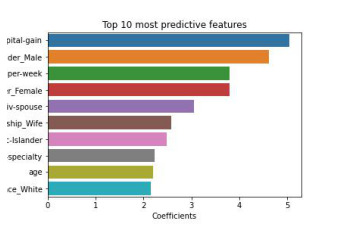

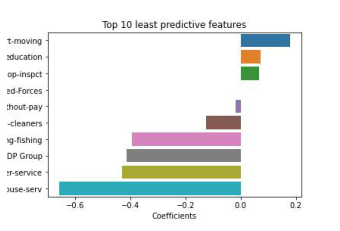

                       SGD Classification Report

              precision    recall  f1-score   support

         0.0       0.84      0.74      0.79     24355
         1.0       0.77      0.86      0.81     24355

    accuracy                           0.80     48710
   macro avg       0.81      0.80      0.80     48710
weighted avg       0.81      0.80      0.80     48710


                        precision score

Scores: [0.77293659 0.71717172 0.76694619 0.87867178 0.76108628 0.76272948
 0.78172969 0.7593985  0.76288301 0.79200308]

Mean of the scores: 0.7755556306651717

Standard deviation of the scores: 0.03902148182704336



                        recall score

Scores: [0.89573071 0.93267652 0.90106732 0.56486043 0.908867   0.90431211
 0.85749487 0.91252567 0.89979466 0.84599589]

Mean of the scores: 0.8623325173728771

Standard deviation of the scores: 0.1020757288798986



                        f1 score

Scores: [0.82981555 0.81084939 0.82861457 0.68765617 0.82843779 0.827508

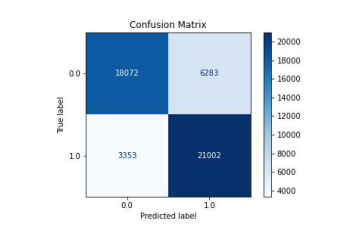

Income lower than 50k: ROC AUC=0.500
Income higher than 50k: ROC AUC=0.893


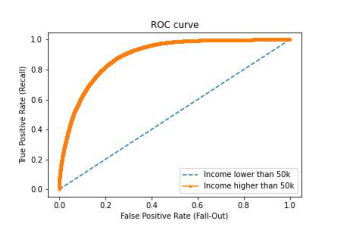


       ***************  Logistic_regression  ***************



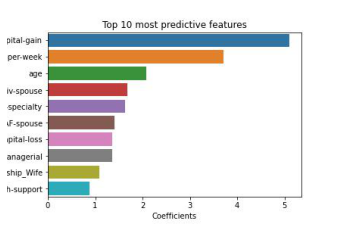

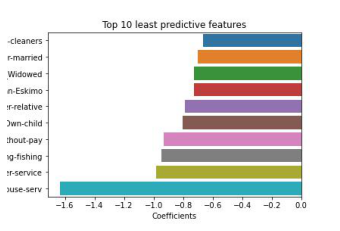

                       Logistic_regression Classification Report

              precision    recall  f1-score   support

         0.0       0.83      0.78      0.81     24355
         1.0       0.80      0.84      0.82     24355

    accuracy                           0.81     48710
   macro avg       0.81      0.81      0.81     48710
weighted avg       0.81      0.81      0.81     48710


                        precision score

Scores: [0.8017412  0.78974158 0.80124951 0.80195695 0.79187621 0.79380635
 0.79248238 0.7981904  0.79457364 0.78947368]

Mean of the scores: 0.7955091904805255

Standard deviation of the scores: 0.004651659062771395



                        recall score

Scores: [0.8316913  0.82799672 0.84236453 0.841133   0.84031199 0.83162218
 0.8312115  0.83326489 0.84188912 0.85010267]

Mean of the scores: 0.8371587886021787

Standard deviation of the scores: 0.006616499906219255



                        f1 score

Scores: [0.81644167 0.80841683 0.82129278 0.82107794 

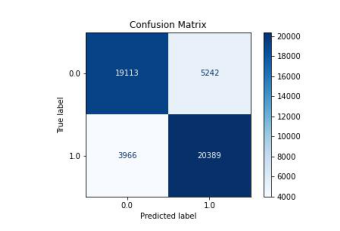

Income lower than 50k: ROC AUC=0.500
Income higher than 50k: ROC AUC=0.893


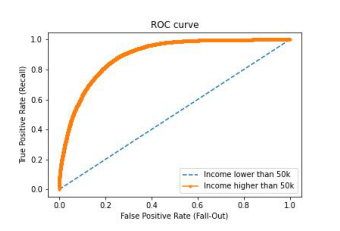


       ***************  Support_vector_machine  ***************

                       Support_vector_machine Classification Report

              precision    recall  f1-score   support

         0.0       0.83      0.76      0.79     24355
         1.0       0.78      0.84      0.81     24355

    accuracy                           0.80     48710
   macro avg       0.80      0.80      0.80     48710
weighted avg       0.80      0.80      0.80     48710


                        precision score

Scores: [0.78557729 0.77589526 0.77294867 0.78454511 0.77997716 0.7743295
 0.77726751 0.78106964 0.77883881 0.77304702]

Mean of the scores: 0.7783495974903237

Standard deviation of the scores: 0.004260915904273536



                        recall score

Scores: [0.8407225  0.8271757  0.84688013 0.84605911 0.841133   0.82997947
 0.83408624 0.83367556 0.83737166 0.85749487]

Mean of the scores: 0.8394578246224498

Standard deviation of the scores: 0.008577520424725805



                   

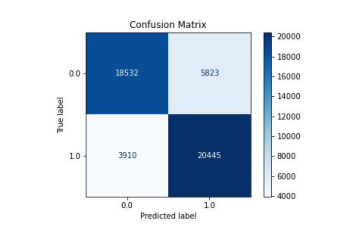

Income lower than 50k: ROC AUC=0.500
Income higher than 50k: ROC AUC=0.888


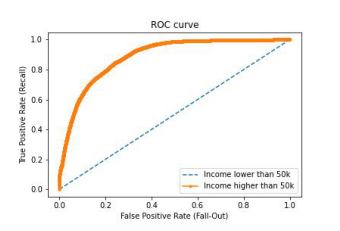


       ***************  Decision_tree  ***************



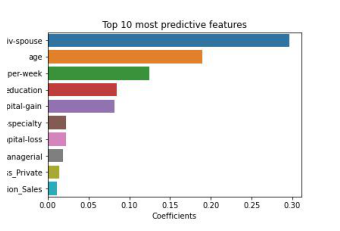

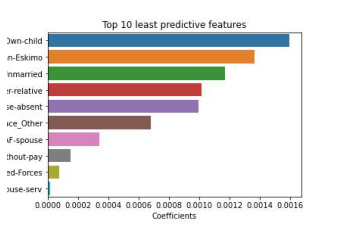

                       Decision_tree Classification Report

              precision    recall  f1-score   support

         0.0       0.84      0.86      0.85     24355
         1.0       0.85      0.84      0.85     24355

    accuracy                           0.85     48710
   macro avg       0.85      0.85      0.85     48710
weighted avg       0.85      0.85      0.85     48710


                        precision score

Scores: [0.85       0.83900929 0.83704453 0.85761453 0.8623298  0.8451514
 0.85818882 0.86607143 0.86192308 0.86140147]

Mean of the scores: 0.8538734353430595

Standard deviation of the scores: 0.009846927492459533



                        recall score

Scores: [0.68390805 0.66748768 0.67898194 0.85303777 0.93596059 0.90554415
 0.91457906 0.91622177 0.92032854 0.9137577 ]

Mean of the scores: 0.8389807237771553

Standard deviation of the scores: 0.10815763683815853



                        f1 score

Scores: [0.75796178 0.74348422 0.74977335 0.85532002 0.897637

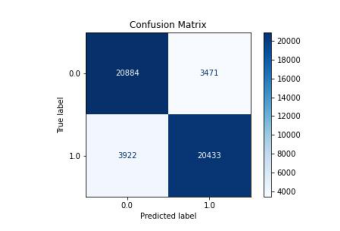

Income lower than 50k: ROC AUC=0.500
Income higher than 50k: ROC AUC=0.999


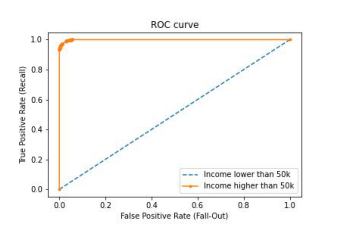


       ***************  Random_forest  ***************



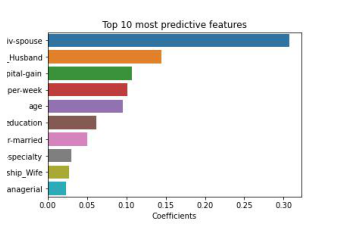

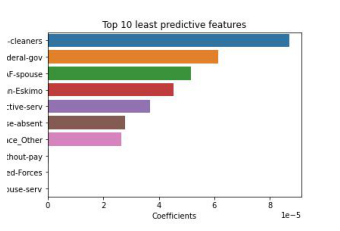

                       Random_forest Classification Report

              precision    recall  f1-score   support

         0.0       0.89      0.75      0.81     24355
         1.0       0.78      0.91      0.84     24355

    accuracy                           0.83     48710
   macro avg       0.84      0.83      0.83     48710
weighted avg       0.84      0.83      0.83     48710


                        precision score

Scores: [0.7853461  0.77720398 0.77970386 0.78558813 0.78519036 0.77661431
 0.78773092 0.79137447 0.79143258 0.77766393]

Mean of the scores: 0.7837848656437945

Standard deviation of the scores: 0.005368155520012824



                        recall score

Scores: [0.87561576 0.86494253 0.886289   0.91297209 0.9228243  0.9137577
 0.92813142 0.92689938 0.92566735 0.93511294]

Mean of the scores: 0.9092212466661946

Standard deviation of the scores: 0.023337689926362273



                        f1 score

Scores: [0.82802795 0.81872936 0.82958694 0.84450351 0.84846

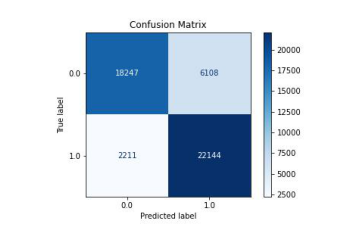

Income lower than 50k: ROC AUC=0.500
Income higher than 50k: ROC AUC=0.920


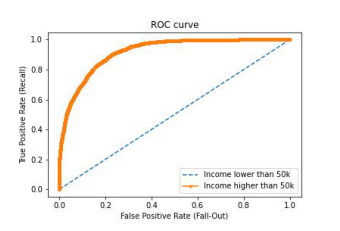


       ***************  Gaussian_naive_bayes  ***************



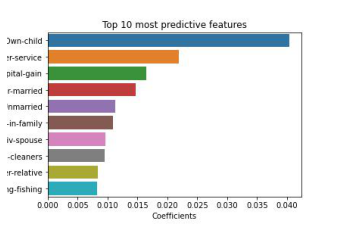

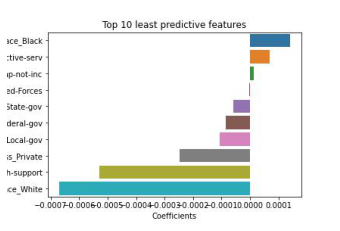

                       Gaussian_naive_bayes Classification Report

              precision    recall  f1-score   support

         0.0       0.87      0.66      0.75     24355
         1.0       0.73      0.90      0.80     24355

    accuracy                           0.78     48710
   macro avg       0.80      0.78      0.78     48710
weighted avg       0.80      0.78      0.78     48710


                        precision score

Scores: [0.72600927 0.72544418 0.72055427 0.73025435 0.72099901 0.72733311
 0.7239894  0.72668701 0.73043767 0.72697368]

Mean of the scores: 0.7258681957893447

Standard deviation of the scores: 0.0031596398301239124



                        recall score

Scores: [0.90065681 0.88834154 0.89655172 0.89573071 0.90065681 0.89938398
 0.8973306  0.88008214 0.90472279 0.90759754]

Mean of the scores: 0.8971054645748409

Standard deviation of the scores: 0.0075323992601607674



                        f1 score

Scores: [0.80395749 0.79867134 0.79897567 0.804572

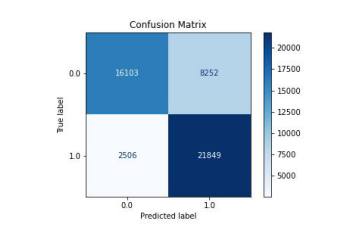

Income lower than 50k: ROC AUC=0.500
Income higher than 50k: ROC AUC=0.865


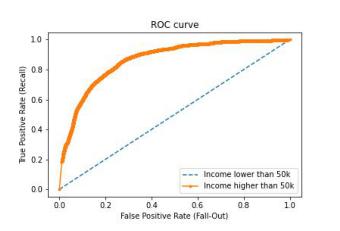


       ***************  K-Nearest_neighbors  ***************

                       K-Nearest_neighbors Classification Report

              precision    recall  f1-score   support

         0.0       0.88      0.79      0.83     24355
         1.0       0.81      0.89      0.85     24355

    accuracy                           0.84     48710
   macro avg       0.85      0.84      0.84     48710
weighted avg       0.85      0.84      0.84     48710


                        precision score

Scores: [0.80837859 0.80660194 0.81588167 0.81002244 0.81172161 0.79878701
 0.80468178 0.82259259 0.80811007 0.80611511]

Mean of the scores: 0.809289281035513

Standard deviation of the scores: 0.006147642674653737



                        recall score

Scores: [0.85550082 0.85262726 0.86042693 0.88916256 0.90968801 0.91950719
 0.90349076 0.91211499 0.91663244 0.92032854]

Mean of the scores: 0.8939479504894077

Standard deviation of the scores: 0.02620074943360306



                        f1

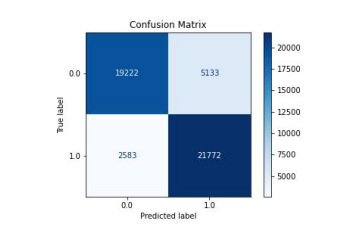

Income lower than 50k: ROC AUC=0.500
Income higher than 50k: ROC AUC=0.964


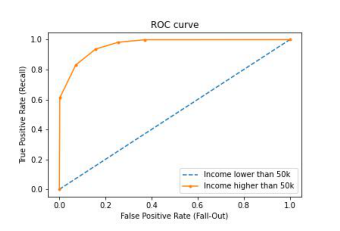


       ***************  Gradient_boosting  ***************



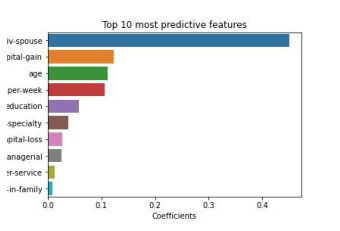

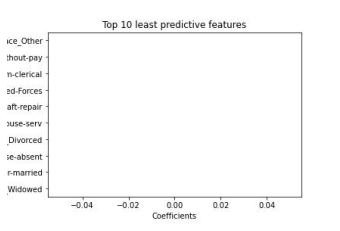

                       Gradient_boosting Classification Report

              precision    recall  f1-score   support

         0.0       0.89      0.82      0.85     24355
         1.0       0.83      0.90      0.86     24355

    accuracy                           0.86     48710
   macro avg       0.86      0.86      0.86     48710
weighted avg       0.86      0.86      0.86     48710


                        precision score

Scores: [0.83354193 0.81529699 0.8254354  0.82915718 0.83253939 0.82415177
 0.83461963 0.83832778 0.83685577 0.83309144]

Mean of the scores: 0.8303017263935084

Standard deviation of the scores: 0.006612571779948256



                        recall score

Scores: [0.82019704 0.8226601  0.83661741 0.89655172 0.93267652 0.92772074
 0.93264887 0.93059548 0.92689938 0.94291581]

Mean of the scores: 0.8969483078935745

Standard deviation of the scores: 0.04763366247012269



                        f1 score

Scores: [0.82681564 0.81896199 0.83098879 0.86153846 0.8

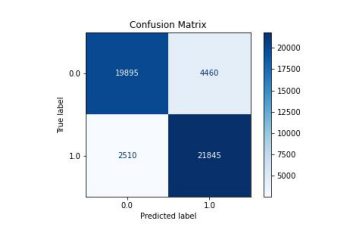

Income lower than 50k: ROC AUC=0.500
Income higher than 50k: ROC AUC=0.941


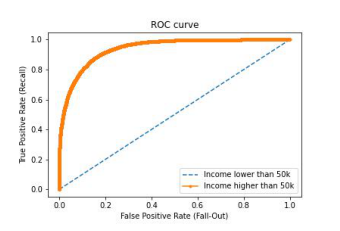


       ***************  Linear_discriminant_analysis  ***************



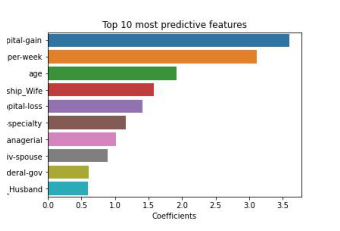

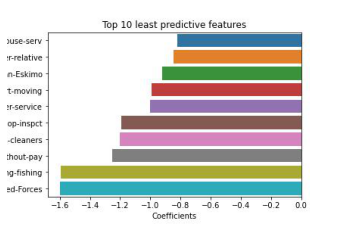

                       Linear_discriminant_analysis Classification Report

              precision    recall  f1-score   support

         0.0       0.83      0.76      0.80     24355
         1.0       0.78      0.85      0.81     24355

    accuracy                           0.80     48710
   macro avg       0.81      0.80      0.80     48710
weighted avg       0.81      0.80      0.80     48710


                        precision score

Scores: [0.78552279 0.77646611 0.78741048 0.78479576 0.78190691 0.77837014
 0.77570449 0.78217822 0.78078078 0.77662338]

Mean of the scores: 0.7809759059416234

Standard deviation of the scores: 0.0039099889899369454



                        recall score

Scores: [0.84195402 0.83702791 0.85755337 0.85180624 0.85509031 0.83942505
 0.83655031 0.84353183 0.85420945 0.85954825]

Mean of the scores: 0.8476696742564476

Standard deviation of the scores: 0.008416562783895857



                        f1 score

Scores: [0.81276006 0.80561043 0.82098644 0

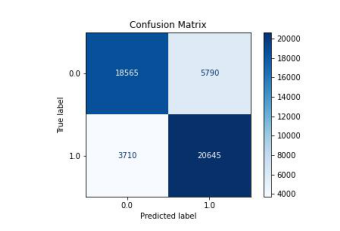

Income lower than 50k: ROC AUC=0.500
Income higher than 50k: ROC AUC=0.889


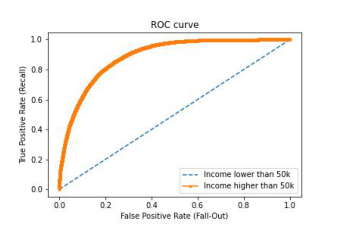


       ***************  Bagging  ***************



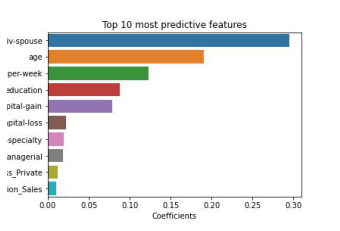

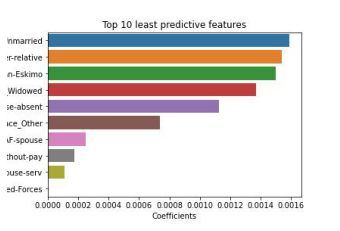

                       Bagging Classification Report

              precision    recall  f1-score   support

         0.0       0.86      0.88      0.87     24355
         1.0       0.88      0.86      0.87     24355

    accuracy                           0.87     48710
   macro avg       0.87      0.87      0.87     48710
weighted avg       0.87      0.87      0.87     48710


                        precision score

Scores: [0.87336473 0.85942327 0.85894207 0.88398018 0.87984791 0.87089381
 0.88305215 0.88746605 0.88417431 0.89000386]

Mean of the scores: 0.8771148337925846

Standard deviation of the scores: 0.010530766085909948



                        recall score

Scores: [0.68513957 0.68513957 0.6999179  0.87889984 0.9499179  0.93634497
 0.94579055 0.93921971 0.94989733 0.94702259]

Mean of the scores: 0.8617289932329231

Standard deviation of the scores: 0.11415338466639222



                        f1 score

Scores: [0.7678859  0.76244861 0.77131871 0.88143269 0.91354126 0.

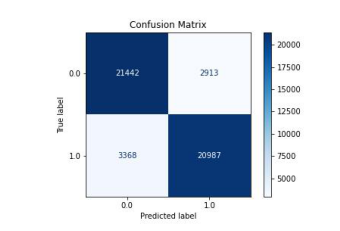

Income lower than 50k: ROC AUC=0.500
Income higher than 50k: ROC AUC=0.997


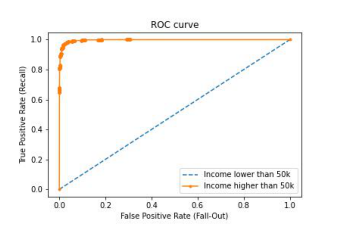


       ***************  Neural_network  ***************

                       Neural_network Classification Report

              precision    recall  f1-score   support

         0.0       0.89      0.80      0.84     24355
         1.0       0.82      0.90      0.86     24355

    accuracy                           0.85     48710
   macro avg       0.85      0.85      0.85     48710
weighted avg       0.85      0.85      0.85     48710


                        precision score

Scores: [0.82311516 0.79018359 0.83143219 0.82537879 0.85283474 0.80678206
 0.808839   0.83508246 0.81947913 0.78250901]

Mean of the scores: 0.8175636127573244

Standard deviation of the scores: 0.020024279254790008



                        recall score

Scores: [0.81568144 0.86576355 0.80788177 0.89449918 0.87068966 0.93798768
 0.94702259 0.91498973 0.94332649 0.98110883]

Mean of the scores: 0.8978950917618338

Standard deviation of the scores: 0.054724104883165564



                        f1 score



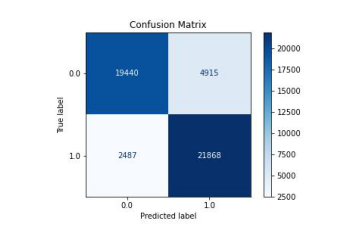

Income lower than 50k: ROC AUC=0.500
Income higher than 50k: ROC AUC=0.947


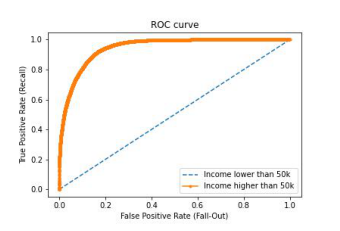


       ***************  AdaBoost  ***************



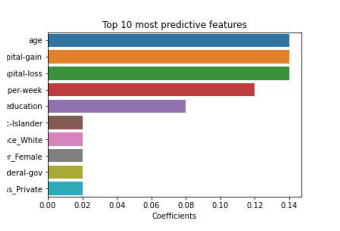

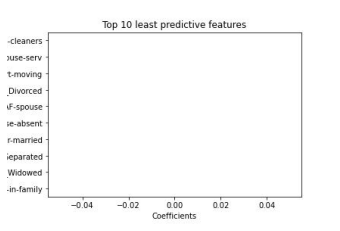

                       AdaBoost Classification Report

              precision    recall  f1-score   support

         0.0       0.86      0.82      0.84     24355
         1.0       0.83      0.87      0.85     24355

    accuracy                           0.84     48710
   macro avg       0.85      0.84      0.84     48710
weighted avg       0.85      0.84      0.84     48710


                        precision score

Scores: [0.82581189 0.81544885 0.8239466  0.83260611 0.82690854 0.82424242
 0.84074217 0.84603361 0.83587786 0.83333333]

Mean of the scores: 0.8304951394737436

Standard deviation of the scores: 0.008550426693125727



                        recall score

Scores: [0.80377668 0.80172414 0.81075534 0.86165846 0.89819376 0.8936345
 0.89322382 0.88911704 0.89938398 0.90349076]

Mean of the scores: 0.8654958477053641

Standard deviation of the scores: 0.04082535096646606



                        f1 score

Scores: [0.81464531 0.80852826 0.81729774 0.8468832  0.86107832 0.

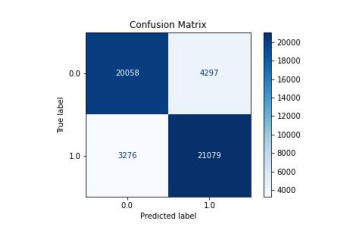

Income lower than 50k: ROC AUC=0.500
Income higher than 50k: ROC AUC=0.928


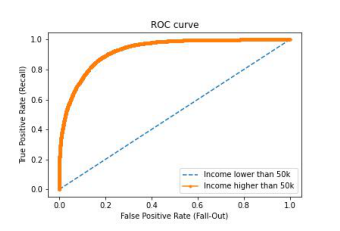


       ***************  Extra_trees  ***************



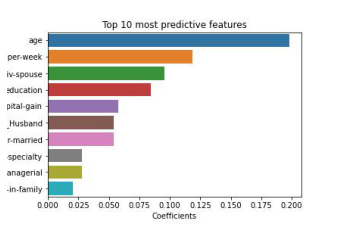

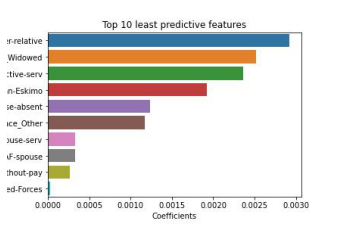

                       Extra_trees Classification Report

              precision    recall  f1-score   support

         0.0       0.89      0.87      0.88     24355
         1.0       0.87      0.89      0.88     24355

    accuracy                           0.88     48710
   macro avg       0.88      0.88      0.88     48710
weighted avg       0.88      0.88      0.88     48710


                        precision score

Scores: [0.86946494 0.86832413 0.86857936 0.88014383 0.87758945 0.86263531
 0.87608943 0.8847032  0.87537651 0.88286581]

Mean of the scores: 0.8745771961852187

Standard deviation of the scores: 0.006767883091768545



                        recall score

Scores: [0.77380952 0.77422003 0.77052545 0.9043514  0.95648604 0.94907598
 0.94948665 0.95482546 0.95482546 0.95646817]

Mean of the scores: 0.8944074171479823

Standard deviation of the scores: 0.08090910344437814



                        f1 score

Scores: [0.81885317 0.81857639 0.81661953 0.89208342 0.9153408

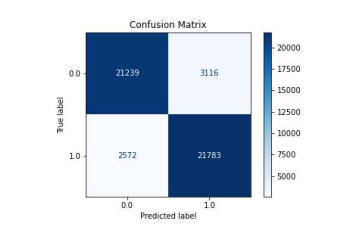

Income lower than 50k: ROC AUC=0.500
Income higher than 50k: ROC AUC=0.999


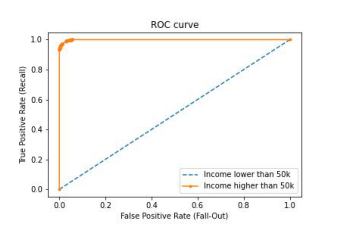

In [467]:
for model_name,model in model_dict.items():
    evaluate_model(model,model_name,X_train_copy_prep,y_train_copy_prep)

In [470]:
create_summary_table(summary_data)

## 5.3. Analyze the most significant variables for each algorithm.
### (For each model, use N-fold cross-validation and compute the mean and standard deviation of the performance measure on the N folds)

Done in quick models comparison

## 5.4 Analyze the types of errors the models make.

### 5.4.1 While keeping all the features

We will focus on 5 models: Random forest, Bagging, Gradient boosting, KNN, and Neural network.

* For Random forest: Looking at the confusion matrix, the estimator is making more errors on False Positive(6108 times), meaning that we are predicting an income higher than 50K but the income is actually lower than 50K. False Negative is low at 2211 times.
* For KNN: Looking at the confusion matrix, the estimator is making also errors on False Positive but a bit less than the Random forest(5133 times). False negative is low as well at 2583 times
* For Gradient Boosting: Looking at the confusion matrix, the estimator is making some errors on False Positive but way less than the Random forest or KNN(4460 times). False negative is relatively low at 2510 times.
* For Bagging: False positive is low compare to the other models at 2913 times. False negative is high at 3368 times.
* For neural network: False positive is high at 4915 times and False negative is low at 2487 times.


Conclusion: It seems that in general, the model are making more errors on False Positive than on False Negative except for the Bagging model.

Solution to this issue would be for example to gather more data that represent people with an income more than 50K. The root of this issue would be the fact that we have balance the data set using the SMOTE method(by duplicating the minority class)

### 5.4.2 While dropping native-country and occupation

## 5.5 Perform a quick round of feature selection and engineering.

In [195]:
# Dropping drop the 10 least predictive features and retrain the model

In [477]:
#changing the summary data to a numpy array for easier manipulation
np_summary_data = np.array(summary_data)

In [475]:
pd.set_option('max_colwidth', 2000)
model_ft_to_drop_df_all = pd.DataFrame(np_summary_data[:,[0,11]], columns=['Model name','least predictive feat'])

In [505]:
# extract the most promising model: Random forest, Bagging, Gradient boosting, KNN, and Neural network.
model_ft_to_drop_df = model_ft_to_drop_df_all.iloc[[4,6,7,9,10]]
# regular expression to extract the feature names
patterns = ':\s*([^:.<]+)<'

In [503]:
# extract the feature names from the summary data string
for index, row in model_ft_to_drop_df.iterrows():
    if row['least predictive feat'] != 'No coeficient or feature importance for this model':
        row['least predictive feat'] = re.findall(patterns,row['least predictive feat'])

In [504]:
model_ft_to_drop_df

Model name  \
4         Random_forest   
6   K-Nearest_neighbors   
7     Gradient_boosting   
9               Bagging   
10       Neural_network   

                                                                                                                                                                                                                                                         least predictive feat  
4   [occupation_Handlers-cleaners, workclass_Federal-gov, marital-status_Married-AF-spouse, race_Amer-Indian-Eskimo, occupation_Protective-serv, marital-status_Married-spouse-absent, race_Other, workclass_Without-pay, occupation_Armed-Forces, occupation_Priv-house-serv]  
6                                                                                                                                                                                                                           No coeficient or feature importance for this model  
7              [race_Other, workclass_Without-pay, occupation_Adm-clerical, occupation_Armed-Forces, occupation_Craft-repair, occupation_Priv-house-serv, marital-status_Divorced, marital-status_Married-spouse-absent, marital-status_Never-married, marital-status_Widowed]  
9       [relationship_Unmarried, relationship_Other-relative, race_Amer-Indian-Eskimo, marital-status_Widowed, marital-status_Married-spouse-absent, race_Other, marital-status_Married-AF-spouse, workclass_Without-pay, occupation_Priv-house-serv, occupation_Armed-Forces]  
10                                                                                                                                                                                                                          No coeficient or feature importance for this model

In [ ]:
# TODO: implement the same drop methodology use in FeatureToDrop class in DropMaritalOrRelationship class
# TODO: create a save the summary table data frame mechanism
# TODO: using the bottom 10 features, toggle to drop occupation, native country, workclass, (marital and relationship) and compare the result in the summary table. Automate this with a loop/combination